In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import zipfile
import matplotlib.gridspec as gridspec
import re
from sklearn.feature_extraction.text import TfidfVectorizer
import nltk
import chardet
from nltk import pos_tag, word_tokenize
from nltk.corpus import stopwords
from collections import Counter
import pickle as pkl
from google.colab import drive

nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('stopwords')
drive.mount('/content/drive')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

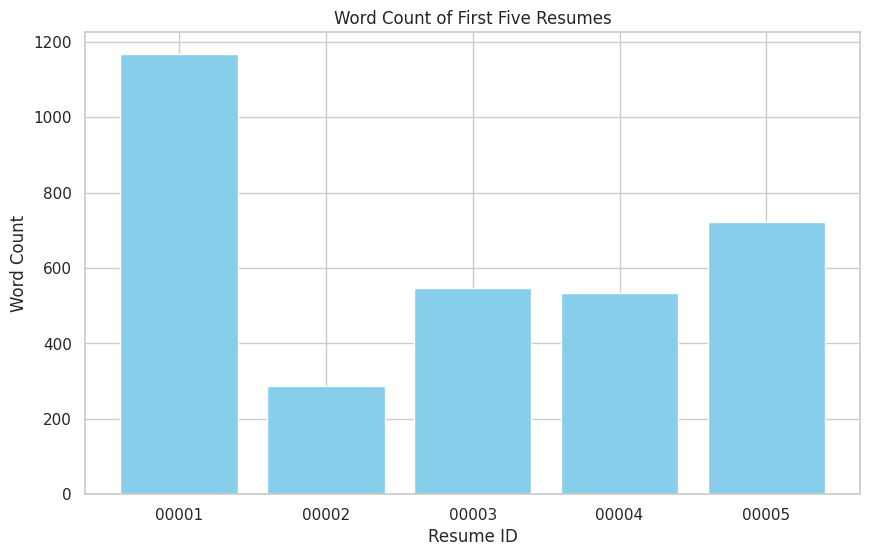

In [ ]:
import zipfile
import os
import chardet
import matplotlib.pyplot as plt

zip_path = '/content/drive/MyDrive/resumes_corpus.zip'

def detect_encoding(file_bytes):
    result = chardet.detect(file_bytes)
    encoding = result['encoding']
    confidence = result['confidence']
    if encoding and confidence > 0.5:
        return encoding
    else:
        return 'utf-8'

resume_lengths = []

try:
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        all_files = zip_ref.namelist()
        txt_files = [f for f in all_files if f.lower().endswith('.txt')]
        txt_basenames = {os.path.splitext(os.path.basename(f))[0]: f for f in txt_files}
        sorted_basenames = sorted(txt_basenames.keys())[:5]

        for basename in sorted_basenames:
            resume_path = txt_basenames[basename]
            with zip_ref.open(resume_path) as resume_file:
                resume_bytes = resume_file.read()
                encoding = detect_encoding(resume_bytes)
                try:
                    resume_content = resume_bytes.decode(encoding)
                except UnicodeDecodeError:
                    resume_content = resume_bytes.decode('utf-8', errors='replace')

                word_count = len(resume_content.split())
                resume_lengths.append((basename, word_count))

    # Plotting
    basenames, lengths = zip(*resume_lengths)
    plt.figure(figsize=(10, 6))
    plt.bar(basenames, lengths, color='skyblue')
    plt.xlabel('Resume ID')
    plt.ylabel('Word Count')
    plt.title('Word Count of First Five Resumes')
    plt.show()

except Exception as e:
    print(f"An error occurred: {e}")


In [ ]:
from charset_normalizer import from_bytes

def detect_encoding(file_bytes):
    """
    Detects the encoding of a byte string using charset-normalizer.
    Returns the detected encoding or 'utf-8' as a fallback.
    """
    result = from_bytes(file_bytes).best()
    if result and result.encoding:
        return result.encoding
    else:
        return 'utf-8'  # Fallback encoding


In [ ]:
def detect_encoding(file_bytes):
    """
    Detects the encoding of a byte string using chardet.
    Returns the detected encoding or 'utf-8' as a fallback.
    """
    result = chardet.detect(file_bytes)
    encoding = result['encoding']
    confidence = result['confidence']
    if encoding and confidence > 0.5:
        return encoding
    else:
        return 'utf-8'  # Fallback encoding


Extracting and reading all ground truth labels

In [ ]:
labels = []

zip_path = '/content/drive/MyDrive/resumes_corpus.zip'
try:
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        # List all files in the zip
        all_files = zip_ref.namelist()

        # Filter out .lab files
        lab_files = [f for f in all_files if f.lower().endswith('.lab')]

        if not lab_files:
            print("No .lab files found in the zip archive.")
        else:
            print(f"Found {len(lab_files)} .lab files.")

            for lab_file in lab_files:
                with zip_ref.open(lab_file) as file:
                    lab_bytes = file.read()
                    encoding = detect_encoding(lab_bytes)
                    try:
                        lab_content = lab_bytes.decode(encoding).strip()
                    except UnicodeDecodeError:
                        # Fallback to 'utf-8' with replacement if decoding fails
                        lab_content = lab_bytes.decode('utf-8', errors='replace').strip()

                    if lab_content:
                        # Split labels by newline and extend the labels list
                        labels_in_file = [label.strip() for label in lab_content.split('\n') if label.strip()]
                        labels.extend(labels_in_file)
                    else:
                        # Handle empty .lab files if necessary
                        pass  # Currently, we're just skipping them

except FileNotFoundError:
    print(f"The file {zip_path} does not exist. Please check the path.")
except zipfile.BadZipFile:
    print(f"The file {zip_path} is not a zip file or it is corrupted.")
except Exception as e:
    print(f"An unexpected error occurred: {e}")


Found 29783 .lab files.
An unexpected error occurred: name 'chardet' is not defined


In [ ]:
labels = []

try:
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        # List all files in the zip
        all_files = zip_ref.namelist()

        # Filter out .lab files
        lab_files = [f for f in all_files if f.lower().endswith('.lab')]

        if not lab_files:
            print("No .lab files found in the zip archive.")
        else:
            print(f"Found {len(lab_files)} .lab files.")

            for lab_file in lab_files:
                with zip_ref.open(lab_file) as file:
                    lab_bytes = file.read()
                    encoding = detect_encoding(lab_bytes)
                    try:
                        lab_content = lab_bytes.decode(encoding).strip()
                    except UnicodeDecodeError:
                        # Fallback to 'utf-8' with replacement if decoding fails
                        lab_content = lab_bytes.decode('utf-8', errors='replace').strip()

                    if lab_content:
                        # Split labels by newline and extend the labels list
                        labels_in_file = [label.strip() for label in lab_content.split('\n') if label.strip()]
                        # first_label = lab_content.split('\n')[0].strip()
                        # labels_in_file = [first_label]
                        labels.extend(labels_in_file)
                    else:
                        # Handle empty .lab files if necessary
                        pass  # Currently, we're just skipping them

except FileNotFoundError:
    print(f"The file {zip_path} does not exist. Please check the path.")
except zipfile.BadZipFile:
    print(f"The file {zip_path} is not a zip file or it is corrupted.")
except Exception as e:
    print(f"An unexpected error occurred: {e}")



Found 29783 .lab files.


In [ ]:
if labels:
    # Using Counter to count label occurrences
    label_counts = Counter(labels)

    # Convert to DataFrame for easier manipulation and visualization
    label_df = pd.DataFrame(label_counts.items(), columns=['Label', 'Count'])

    # Sort the DataFrame by Count in descending order
    label_df = label_df.sort_values(by='Count', ascending=False).reset_index(drop=True)

    print("\n--- Unique Labels and Their Counts ---")
    print(label_df)
else:
    print("No labels were collected. Please check your .lab files.")



--- Unique Labels and Their Counts ---
                    Label  Count
0      Software_Developer  15013
1           Web_Developer   6594
2   Systems_Administrator   5969
3         Project_manager   4550
4   Network_Administrator   4460
5     Front_End_Developer   3977
6  Database_Administrator   3299
7          Java_Developer   3252
8        Security_Analyst   3022
9        Python_Developer   2836


In [ ]:
label_df.Count.sum()

29035

<ipython-input-13-a104a205bbfa>:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Label', y='Count', data=label_df, palette='viridis')


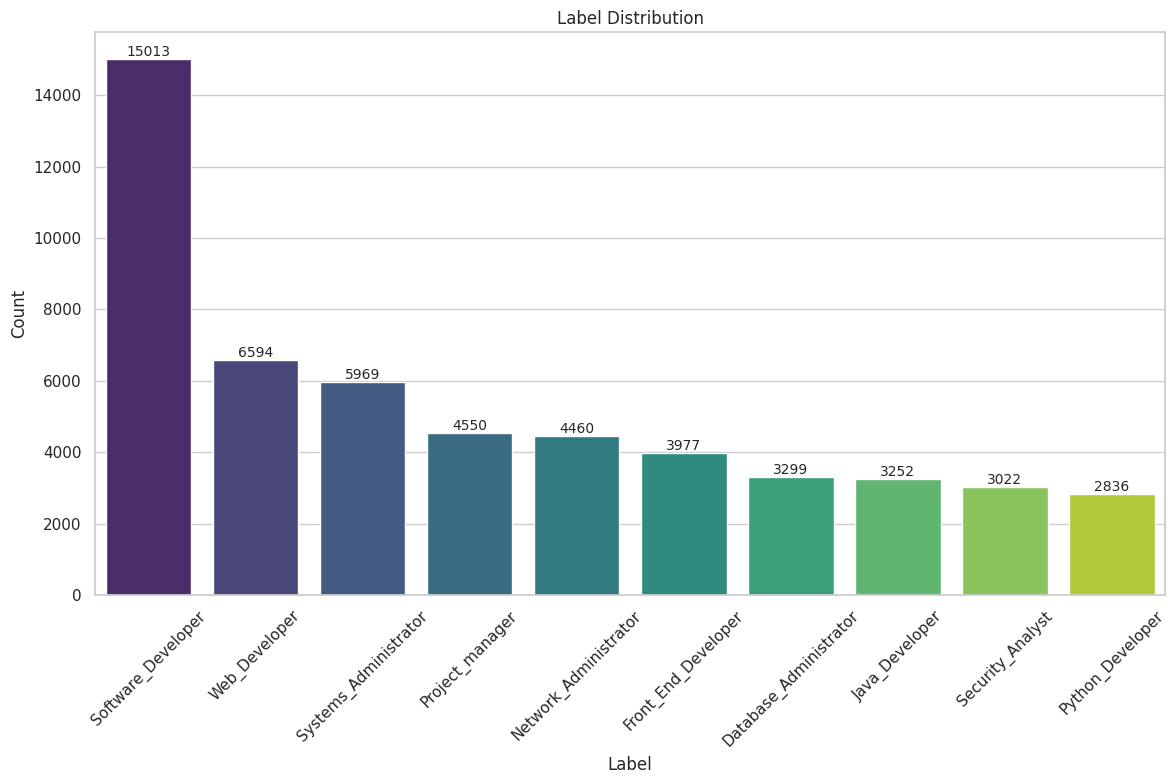

In [ ]:
sns.set(style = 'whitegrid')

plt.figure(figsize=(12,8))
sns.barplot(x='Label', y='Count', data=label_df, palette='viridis')
plt.xlabel('Label')
plt.ylabel('Count')
plt.title('Label Distribution')
plt.xticks(rotation=45)
plt.tight_layout()

for idx, row in label_df.iterrows():
    plt.text(idx, row['Count'], str(row['Count']), ha='center', va='bottom', fontsize=12)

plt.show()

Exploring word length of the resumes

In [ ]:
resumes = []
resume_files = [f for f in all_files if f.lower().endswith('.txt')]


with zipfile.ZipFile(zip_path, 'r') as zip_ref:
  for resume in resume_files:
    with zip_ref.open(resume) as file:
      resume_bytes = file.read()
      encoding = detect_encoding(resume_bytes)
      try:
        resume_content = resume_bytes.decode(encoding).strip()
      except UnicodeDecodeError:
        resume_content = resume_bytes.decode('utf-8', errors='replace').strip()
      if resume_content:
        resumes.append(resume_content)
      else:
        pass


Checkpoint

In [ ]:
import pickle

checkpoint_dir = '/content/drive/MyDrive/checkpoints'
os.makedirs(checkpoint_dir, exist_ok=True)

checkpoint = {
    'labels': labels,
    'resumes': resumes
}


checkpoint_path = os.path.join(checkpoint_dir, 'checkpoint1.pkl')
with open(checkpoint_path, 'wb') as f:
    pickle.dump(checkpoint, f)

print("Checkpoint saved successfully ")

NameError: name 'os' is not defined

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import zipfile
import matplotlib.gridspec as gridspec
import re
from sklearn.feature_extraction.text import TfidfVectorizer
import nltk
import chardet
from nltk import pos_tag, word_tokenize
from nltk.corpus import stopwords
from collections import Counter
import pickle as pkl
from google.colab import drive

nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('stopwords')
drive.mount('/content/drive')


with open('/content/drive/MyDrive/checkpoints/checkpoint1.pkl', 'rb') as f:
    checkpoint = pkl.load(f)

labels = checkpoint['labels']
resumes = checkpoint['resumes']

print("Checkpoint loaded successfully")

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Checkpoint loaded successfully


In [ ]:
lengths = [len(resume.split()) for resume in resumes]
print(np.average(lengths))
print(np.median(lengths))
print(np.min(lengths))
print(np.max(lengths))


979.4155726421112
690.0
2
12844


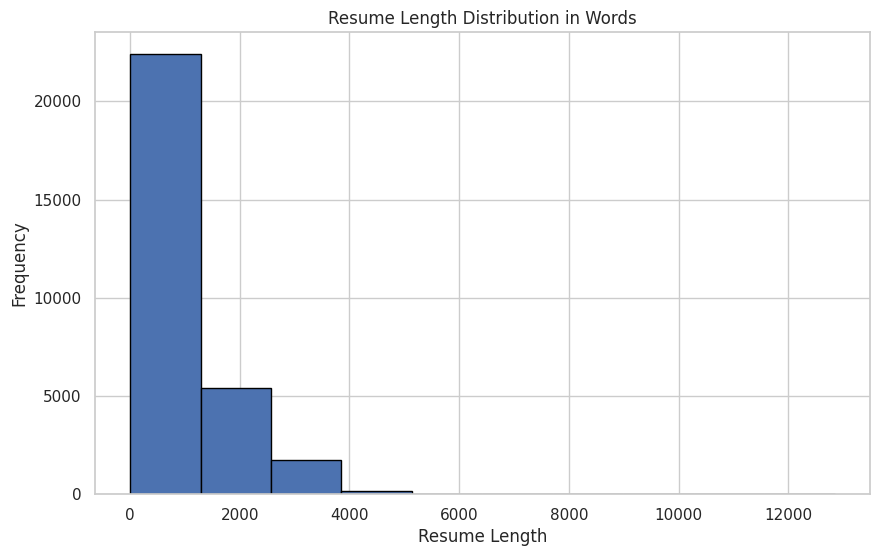

In [ ]:
plt.figure(figsize=(10, 6))
plt.hist(lengths, bins=10, edgecolor='black')
plt.title('Resume Length Distribution in Words')
plt.xlabel('Resume Length')
plt.ylabel('Frequency')
plt.show()


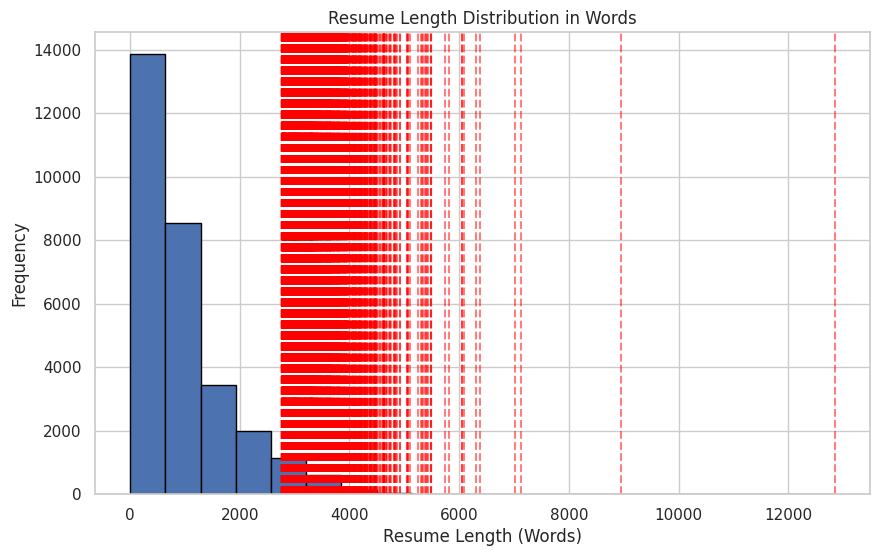

In [ ]:
plt.figure(figsize=(10, 6))
plt.hist(lengths, bins=20, edgecolor='black')
plt.title('Resume Length Distribution in Words')
plt.xlabel('Resume Length (Words)')
plt.ylabel('Frequency')

# Highlight outliers
threshold = np.percentile(lengths, 95)
outliers = [length for length in lengths if length > threshold]
for outlier in outliers:
    plt.axvline(outlier, color='red', linestyle='dashed', alpha=0.5)

plt.show()


Q1: 406.0, Q3: 1277.0, IQR: 871.0
Lower Bound: -900.5, Upper Bound: 2583.5
Number of resumes: 29783
Number of resumes after excluding outliers: 27855
Number of outliers excluded: 1928


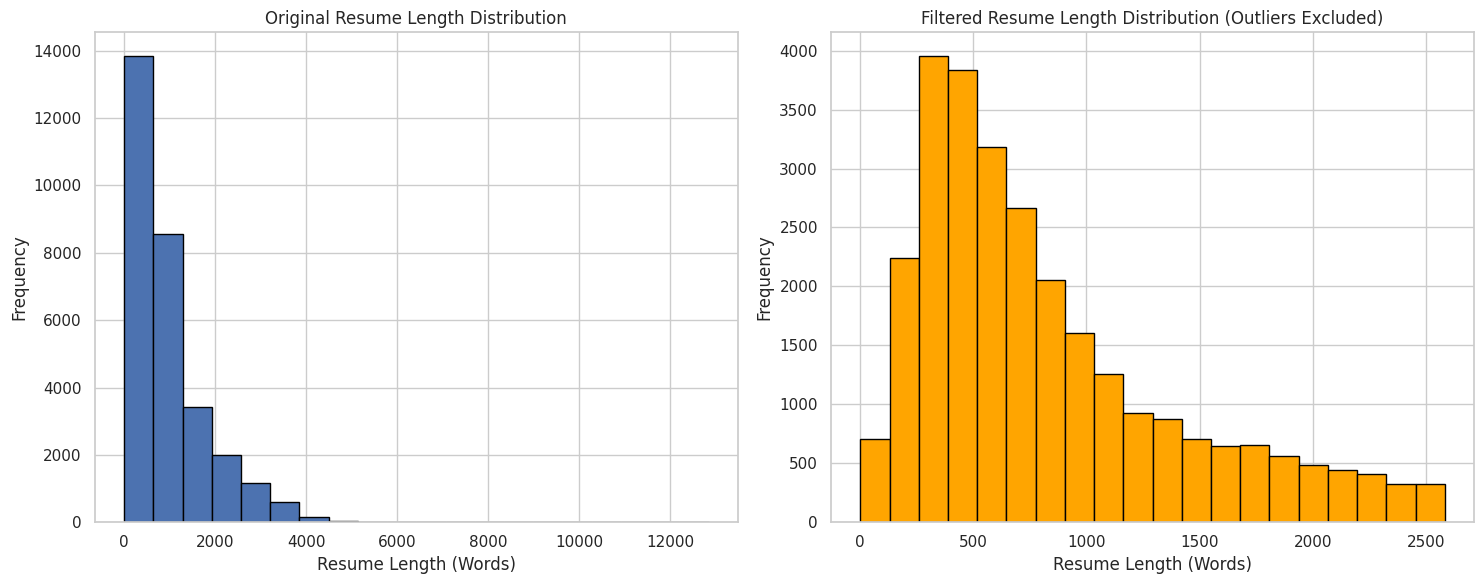

In [ ]:
# Calculate Q1 (25th percentile) and Q3 (75th percentile)
Q1 = np.percentile(lengths, 25)
Q3 = np.percentile(lengths, 75)

# Calculate the Interquartile Range (IQR)
IQR = Q3 - Q1

# Define outlier boundaries
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

print(f"Q1: {Q1}, Q3: {Q3}, IQR: {IQR}")
print(f"Lower Bound: {lower_bound}, Upper Bound: {upper_bound}")

# Filter the lengths to exclude outliers
filtered_lengths = [length for length in lengths if lower_bound <= length <= upper_bound]

# Optionally, identify the outliers
outliers = [length for length in lengths if length < lower_bound or length > upper_bound]

print(f"Number of resumes: {len(lengths)}")
print(f"Number of resumes after excluding outliers: {len(filtered_lengths)}")
print(f"Number of outliers excluded: {len(outliers)}")

# Create a grid for subplots
fig = plt.figure(figsize=(15, 6))
gs = gridspec.GridSpec(1, 2, width_ratios=[1, 1])

# Original Histogram
ax0 = plt.subplot(gs[0])
ax0.hist(lengths, bins=20, edgecolor='black')
ax0.set_title('Original Resume Length Distribution')
ax0.set_xlabel('Resume Length (Words)')
ax0.set_ylabel('Frequency')

# Filtered Histogram
ax1 = plt.subplot(gs[1])
ax1.hist(filtered_lengths, bins=20, edgecolor='black', color='orange')
ax1.set_title('Filtered Resume Length Distribution (Outliers Excluded)')
ax1.set_xlabel('Resume Length (Words)')
ax1.set_ylabel('Frequency')

plt.tight_layout()
plt.show()


First, a little pre-processing.

Following features will be extracted:
1. Word count (already done above);
2. Character count (total number of characters per resume);
3. Average word length (number of characters per word);
4. Unique word count;
5. TF-IDF Vectors;
6. Part-of-Speech Tag Counts.




In [ ]:
# Creating functions to extract features
def average_word_length(text):
  words = re.findall(r'\w+', text)
  return sum(len(word) for word in words) / len(words)

def unique_word_count(text):
  words = re.findall(r'\w+', text)
  return len(set(words))

def pos_tag_counts(text):
  tokens = word_tokenize(text)
  pos_tags = pos_tag(tokens)
  pos_counts = Counter(tag for word, tag in pos_tags)
  return pos_counts

# 1. Word count already extracted above

# 2. Character count
char_counts = [len(resume) for resume in resumes]

# 3. Average word length
avg_word_lengths = [average_word_length(resume) for resume in resumes]

# 4. Unique word count
unique_word_counts = [unique_word_count(resume) for resume in resumes]

# 5. TF-IDF Vectors
vectorizer = TfidfVectorizer(max_features=10, stop_words=stopwords.words('english'))
tfidf_vectors = vectorizer.fit_transform(resumes)
tfidf_df = pd.DataFrame(tfidf_vectors.toarray(), columns=vectorizer.get_feature_names_out())

# 6. Part-of-Speech Tag Counts
# pos_tags = [pos_tag(word_tokenize(resume)) for resume in resumes]
# pos_tags_df = pd.DataFrame(pos_tags).fillna(0).astype(int)

# Combining all features
basic_features_df = pd.DataFrame({
    'Word Count': lengths,
    'Character Count': char_counts,
    'Average Word Length': avg_word_lengths,
    'Unique Word Count': unique_word_counts,
})

resume_df = pd.concat([basic_features_df, tfidf_df], axis=1) # pos_tags_df

In [ ]:
resume_df.head(5)

,Word Count,Character Count,Average Word Length,Unique Word Count,application,data,database,development,experience,server,sql,used,using,web
0,1167,8163,5.660699,528,0.017301,0.089046,0.640584,0.045402,0.044841,0.443203,0.607527,0.019886,0.106944,0.0
1,286,2185,6.339223,191,0.000000,0.179411,0.885022,0.121970,0.090346,0.132292,0.370925,0.080133,0.000000,0.0
2,546,3805,5.648289,215,0.000000,0.374700,0.750901,0.000000,0.389170,0.000000,0.174303,0.000000,0.337509,0.0
3,533,3805,6.116371,276,0.047459,0.529239,0.803292,0.124544,0.061502,0.045028,0.151502,0.000000,0.167634,0.0
4,721,4959,5.765805,389,0.138922,0.297920,0.734811,0.121522,0.090014,0.000000,0.295651,0.239516,0.429360,0.0


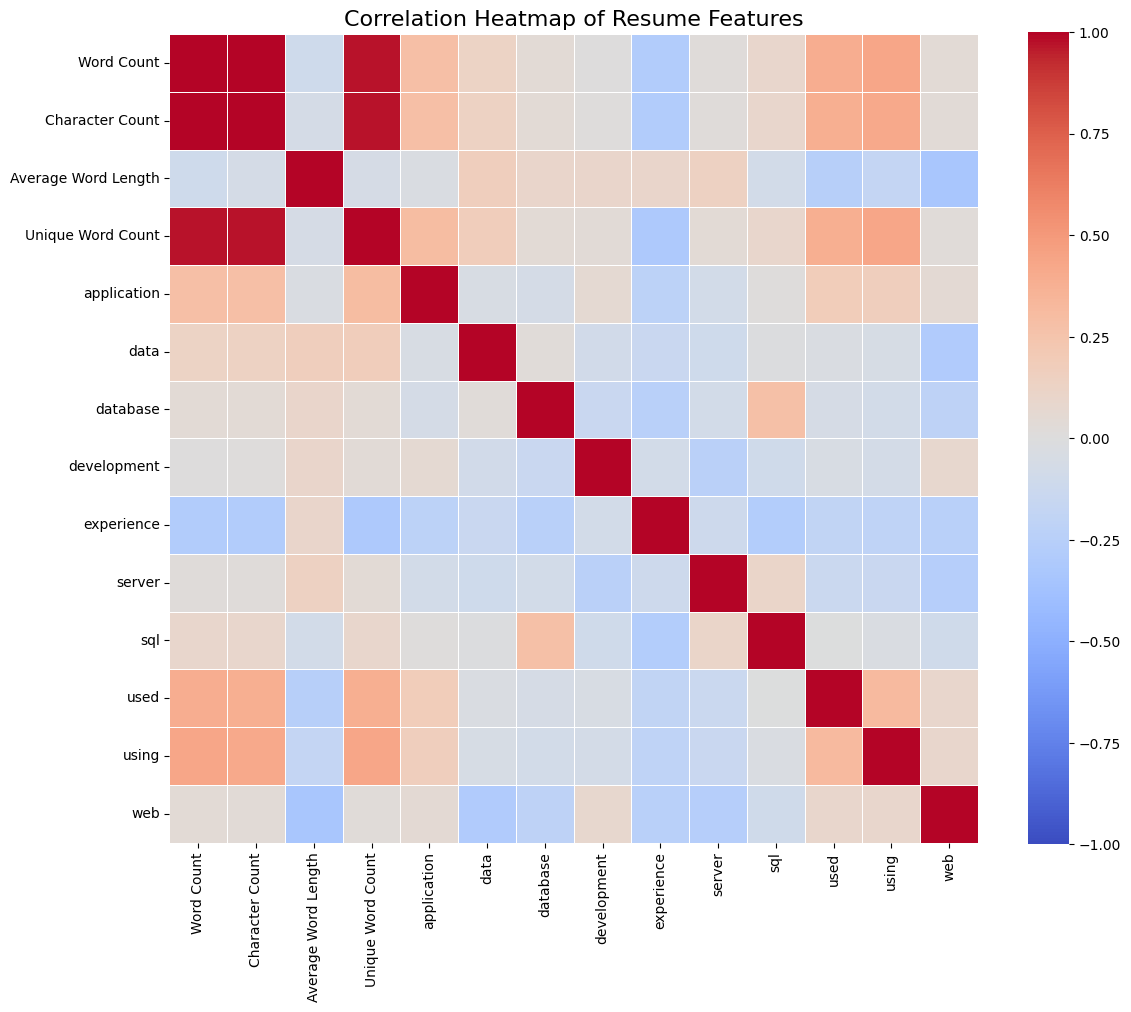

In [ ]:
# Set the size of the plot for better readability
plt.figure(figsize=(12, 10))

# Create the heatmap without annotations
sns.heatmap(resume_df.corr(),
            cmap='coolwarm',
            linewidths=0.5,
            vmin = -1,
            vmax = 1,
            linecolor='white',
            cbar=True,
            square = True)

# Add a title for context
plt.title('Correlation Heatmap of Resume Features', fontsize=16)

# Adjust the layout for better fit
plt.tight_layout()

# Display the heatmap
plt.show()


<img src='data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAEAAAABACAYAAACqaXHeAAAABHNCSVQICAgIfAhkiAAAAAlwSFlz
AAAB+wAAAfsBxc2miwAAABl0RVh0U29mdHdhcmUAd3d3Lmlua3NjYXBlLm9yZ5vuPBoAAA6zSURB
VHic7ZtpeFRVmsf/5966taWqUlUJ2UioBBJiIBAwCZtog9IOgjqACsogKtqirT2ttt069nQ/zDzt
tI4+CrJIREFaFgWhBXpUNhHZQoKBkIUASchWla1S+3ar7r1nPkDaCAnZKoQP/D7mnPOe9/xy76n3
nFSAW9ziFoPFNED2LLK5wcyBDObkb8ZkxuaoSYlI6ZcOKq1eWFdedqNzGHQBk9RMEwFAASkk0Xw3
ETacDNi2vtvc7L0ROdw0AjoSotQVkKSvHQz/wRO1lScGModBFbDMaNRN1A4tUBCS3lk7BWhQkgpD
lG4852/+7DWr1R3uHAZVQDsbh6ZPN7CyxUrCzJMRouusj0ipRwD2uKm0Zn5d2dFwzX1TCGhnmdGo
G62Nna+isiUqhkzuKrkQaJlPEv5mFl2fvGg2t/VnzkEV8F5ioioOEWkLG86fvbpthynjdhXYZziQ
x1hC9J2NFyi8vCTt91Fh04KGip0AaG9zuCk2wQCVyoNU3Hjezee9bq92duzzTmxsRJoy+jEZZZYo
GTKJ6SJngdJqAfRzpze0+jHreUtPc7gpBLQnIYK6BYp/uGhw9YK688eu7v95ysgshcg9qSLMo3JC
4jqLKQFBgdKDPoQ+Pltb8dUyQLpeDjeVgI6EgLIQFT5tEl3rn2losHVsexbZ3EyT9wE1uGdkIPcy
BGxn8QUq1QrA5nqW5i2tLqvrrM9NK6AdkVIvL9E9bZL/oyfMVd/jqvc8LylzRBKDJSzIExwhQzuL
QYGQj4rHfFTc8mUdu3E7yoLtbTe9gI4EqVgVkug2i5+uXGo919ixbRog+3fTbQ8qJe4ZOYNfMoTI
OoshUNosgO60AisX15aeI2PSIp5KiFLI9ubb1vV3Qb2ltwLakUCDAkWX7/nHKRmmGIl9VgYsUhJm
2NXjKYADtM1ygne9QQDIXlk49FBstMKx66D1v4+XuQr7vqTe0VcBHQlRWiOCbmmSYe2SqtL6q5rJ
zsTb7lKx3FKOYC4DoqyS/B5bvLPxvD9Qtf6saxYLQGJErmDOdOMr/zo96km1nElr8bmPOBwI9COv
HnFPRIwmkSOv9kcAS4heRsidOkpeWBgZM+UBrTFAXNYL5Vf2ii9c1trNzpYdaoVil3WIc+wdk+gQ
noie3ecCcxt9ITcLAPWt/laGEO/9U6PmzZkenTtsSMQ8uYywJVW+grCstAvCIaAdArAsIWkRDDs/
KzLm2YcjY1Lv0UdW73HabE9n6V66cxSzfEmuJssTpKGVp+0vHq73FwL46eOjpMpbRAnNmJFrGJNu
Ukf9Yrz+3rghiumCKNXXWPhLYcjxGsIpoCMsIRoFITkW8AuyM8jC1+/QLx4bozCEJIq38+1rtpR6
V/yzb8eBlRb3fo5l783N0CWolAzJHaVNzkrTzlEp2bQ2q3TC5gn6wpnoQAmwSiGh2GitnTmVMc5O
UyfKWUKCIsU7+fZDKwqdT6DDpvkzAX4/+AMFjk0tDp5GRXLpQ2MUmhgDp5gxQT8+Y7hyPsMi8uxF
71H0oebujHALECjFKaW9Lm68n18wXp2kVzIcABytD5iXFzg+WVXkegpAsOOYziqo0OkK76GyquC3
ltZAzMhhqlSNmmWTE5T6e3IN05ITFLM4GdN0vtZ3ob8Jh1NAKXFbm5PtLU/eqTSlGjkNAJjdgn/N
aedXa0tdi7+t9G0FIF49rtMSEgAs1kDLkTPO7ebm4IUWeyh1bKomXqlgMG6kJmHcSM0clYLJ8XtR
1GTnbV3F6I5wCGikAb402npp1h1s7LQUZZSMIfALFOuL3UUrfnS8+rez7v9qcold5tilgHbO1fjK
9ubb17u9oshxzMiUBKXWqJNxd+fqb0tLVs4lILFnK71H0Ind7uiPgACVcFJlrb0tV6DzxqqTIhUM
CwDf1/rrVhTa33/3pGPxJYdQ2l2cbgVcQSosdx8uqnDtbGjh9SlDVSMNWhlnilfqZk42Th2ZpLpf
xrHec5e815zrr0dfBZSwzkZfqsv+1FS1KUknUwPARVvItfKUY+cn57yP7qv07UE3p8B2uhUwLk09
e0SCOrK+hbdYHYLjRIl71wWzv9jpEoeOHhGRrJAzyEyNiJuUqX0g2sBN5kGK6y2Blp5M3lsB9Qh4
y2Ja6x6+i0ucmKgwMATwhSjdUu49tKrQ/pvN5d53ml2CGwCmJipmKjgmyuaXzNeL2a0AkQ01Th5j
2DktO3Jyk8f9vcOBQHV94OK+fPumJmvQHxJoWkaKWq9Vs+yUsbq0zGT1I4RgeH2b5wef7+c7bl8F
eKgoHVVZa8ZPEORzR6sT1BzDUAD/d9F78e2Tzv99v8D+fLVTqAKAsbGamKey1Mt9Ann4eH3gTXTz
idWtAJ8PQWOk7NzSeQn/OTHDuEikVF1R4z8BQCy+6D1aWRfY0tTGG2OM8rRoPaeIj5ZHzJxszElN
VM8K8JS5WOfv8mzRnQAKoEhmt8gyPM4lU9SmBK1MCQBnW4KONT86v1hZ1PbwSXPw4JWussVjtH9Y
NCoiL9UoH/6PSu8jFrfY2t36erQHXLIEakMi1SydmzB31h3GGXFDFNPaK8Rme9B79Ixrd0WN+1ij
NRQ/doRmuFLBkHSTOm5GruG+pFjFdAmorG4IXH1Qua6ASniclfFtDYt+oUjKipPrCQB7QBQ2lrgP
fFzm+9XWUtcqJ3/5vDLDpJ79XHZk3u8nGZ42qlj1+ydtbxysCezrydp6ugmipNJ7WBPB5tydY0jP
HaVNzs3QzeE4ZpTbI+ZbnSFPbVOw9vsfnVvqWnirPyCNGD08IlqtYkh2hjZ5dErEQzoNm+6ykyOt
Lt5/PQEuSRRKo22VkydK+vvS1XEKlhCJAnsqvcVvH7f/ZU2R67eXbMEGAMiIV5oWZWiWvz5Fv2xG
sjqNJQRvn3Rs2lji/lNP19VjAQDgD7FHhujZB9OGqYxRkZxixgRDVlqS6uEOFaJUVu0rPFzctrnF
JqijImVp8dEKVWyUXDk92zAuMZ6bFwpBU1HrOw6AdhQgUooChb0+ItMbWJitSo5Ws3IAOGEOtL53
0vHZih9sC4vtofZ7Qu6523V/fmGcds1TY3V36pUsBwAbSlxnVh2xLfAD/IAIMDf7XYIkNmXfpp2l
18rkAJAy9HKFaIr/qULkeQQKy9zf1JgDB2uaeFNGijo5QsUyacNUUTOnGO42xSnv4oOwpDi1zYkc
efUc3I5Gk6PhyTuVKaOGyLUAYPGIoY9Pu/atL/L92+4q9wbflRJ2Trpm/jPjdBtfnqB/dIThcl8A
KG7hbRuKnb8qsQsVvVlTrwQAQMUlf3kwJI24Z4JhPMtcfng5GcH49GsrxJpGvvHIaeem2ma+KSjQ
lIwUdYyCY8j4dE1KzijNnIP2llF2wcXNnsoapw9XxsgYAl6k+KzUXbi2yP3KR2ecf6z3BFsBICdW
nvnIaG3eHybqX7vbpEqUMT+9OL4Qpe8VON7dXuFd39v19FoAABRVePbGGuXTszO0P7tu6lghUonE
llRdrhArLvmKdh9u29jcFiRRkfLUxBiFNiqSU9icoZQHo5mYBI1MBgBH6wMNb+U7Pnw337H4gi1Y
ciWs+uks3Z9fztUvfzxTm9Ne8XXkvQLHNytOOZeiD4e0PgkAIAYCYknKUNUDSXEKzdWNpnil7r4p
xqkjTarZMtk/K8TQ6Qve78qqvXurGwIJqcOUKfUWHsm8KGvxSP68YudXq4pcj39X49uOK2X142O0
Tz5/u/7TVybqH0rSya6ZBwD21/gubbrgWdDgEOx9W
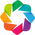

:Chord   [start,end]

In [ ]:
import pandas as pd
import holoviews as hv
from holoviews import opts

# Initialize Holoviews with Bokeh
hv.extension('bokeh')

# Create DataFrame from your existing resume data
df = pd.DataFrame(resume_df)

# Select keyword columns
keywords = ['application', 'data', 'database', 'development', 'experience',
            'server', 'sql', 'used', 'using', 'web','Word Count',
            'Character Count',	'Average Word Length',	'Unique Word Count']

# Compute the correlation matrix
corr_matrix = df.corr()

# Prepare data for the chord diagram as list of tuples (source, target, value)
edges = [
    (source, target, corr_matrix.loc[source, target])
    for i, source in enumerate(keywords)
    for j, target in enumerate(keywords)
    if i < j and corr_matrix.loc[source, target] > 0
]

# Create a list of unique nodes
nodes = list(set([node for edge in edges for node in edge[:2]]))

# Create Holoviews Chord object using edges only
chord = hv.Chord(edges)

# Customize the chord diagram
chord.opts(
    opts.Chord(
        labels='name',
        cmap='Category10',
        edge_color=hv.dim('source').str(),
        node_color=hv.dim('index').str(),
        width=600,
        height=600,
        title='Keyword Correlation Chord Diagram',
        tools=['hover'],
        label_text_font_size='10pt'
    )
)

# Display the chord diagram
chord


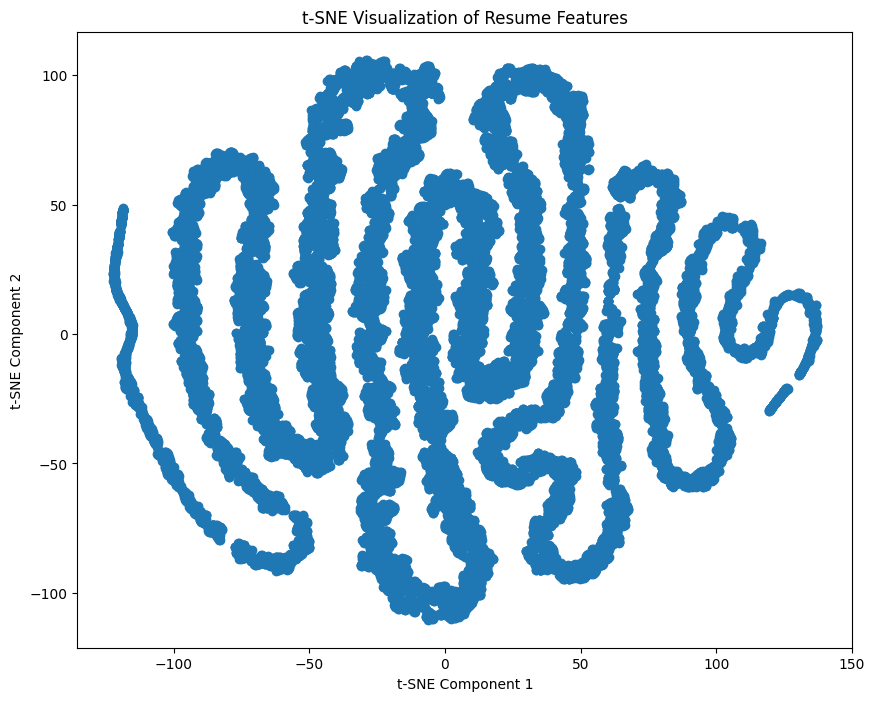

In [ ]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

# Assuming 'resume_df' is your DataFrame with features
X = resume_df

# Apply t-SNE
tsne = TSNE(n_components=2, random_state=42)
X_tsne = tsne.fit_transform(X)

# Create a scatter plot
plt.figure(figsize=(10, 8))
plt.scatter(X_tsne[:, 0], X_tsne[:, 1])
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.title('t-SNE Visualization of Resume Features')
plt.show()


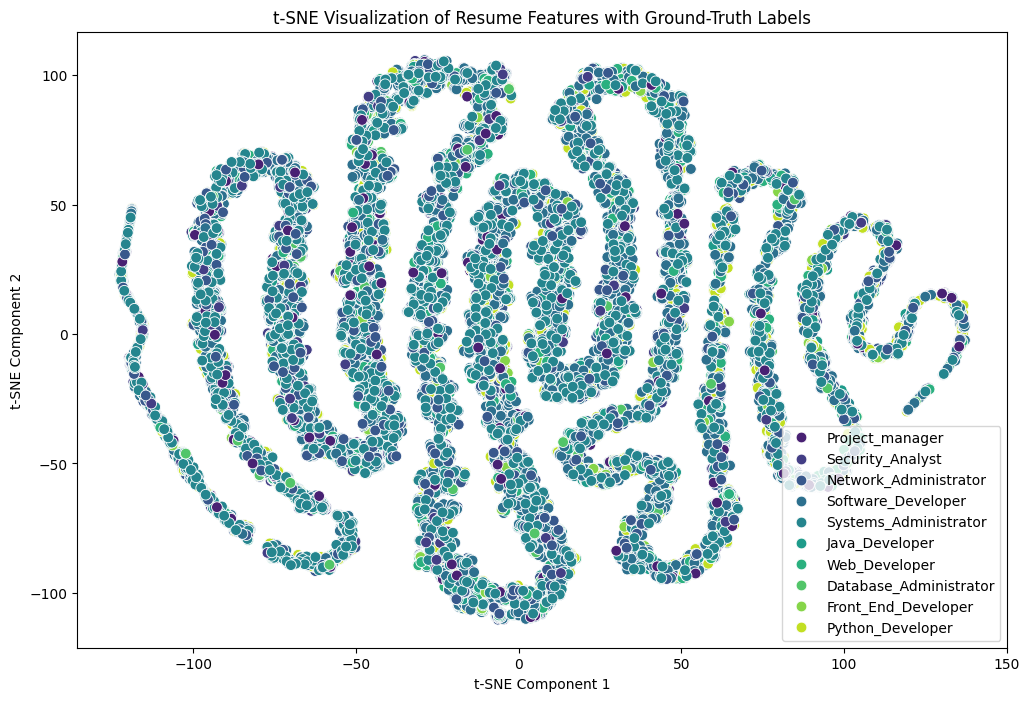

In [ ]:

X = resume_df
label_names = labels[:X.shape[0]]

# Apply t-SNE
tsne = TSNE(n_components=2, random_state=42)
X_tsne = tsne.fit_transform(X)

# Create a scatter plot with color coding based on the labels
plt.figure(figsize=(12, 8))
# Use seaborn to color the points by labels (hue)
sns.scatterplot(x=X_tsne[:, 0], y=X_tsne[:, 1], hue=label_names, palette="viridis", legend='full', s=60)

# Add axis labels and title
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.title('t-SNE Visualization of Resume Features with Ground-Truth Labels')
plt.legend(loc='best')
plt.show()


<ipython-input-71-ca81491e3d95>:16: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[0].set_xticklabels(ax[0].get_xticklabels(), rotation=90)
<ipython-input-71-ca81491e3d95>:20: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[1].set_xticklabels(ax[1].get_xticklabels(), rotation=90)


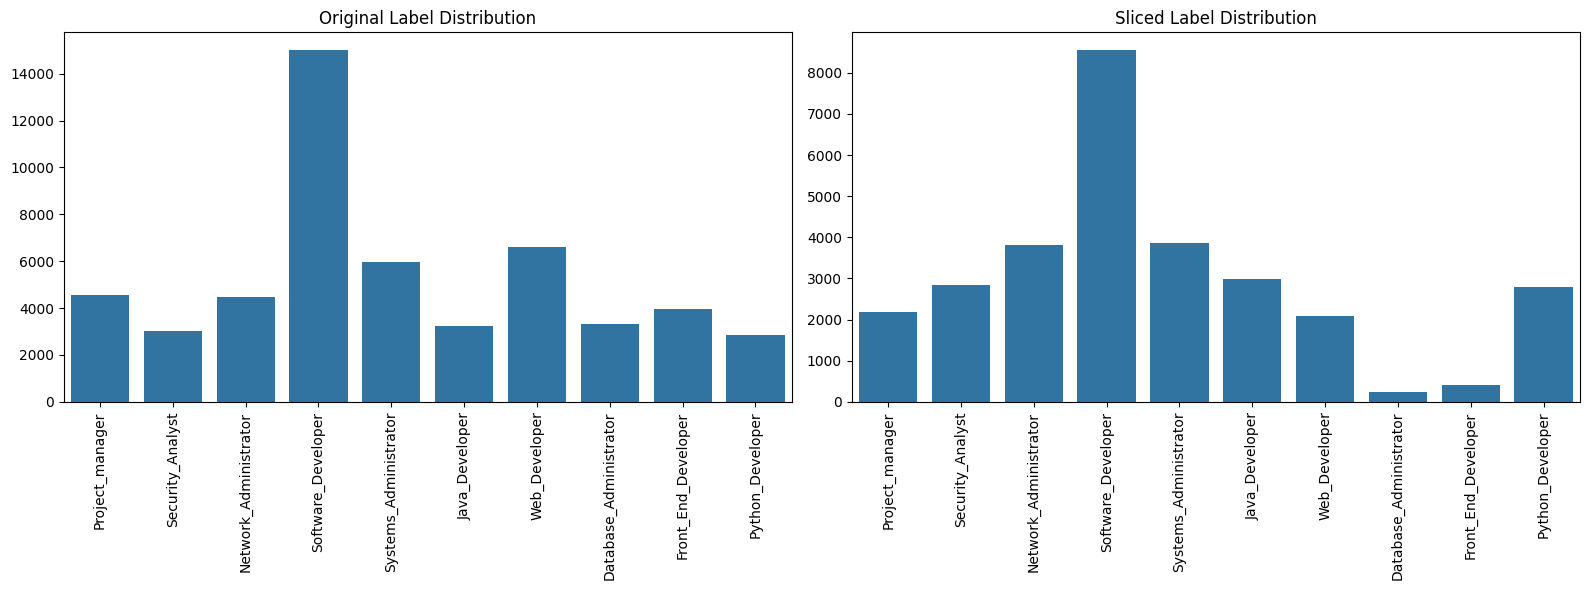

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
from collections import Counter

# Original label distribution (before slicing)
original_label_counts = Counter(labels)

# Label distribution after slicing
sliced_label_counts = Counter(labels[:29783])

# Plot both distributions side by side
fig, ax = plt.subplots(1, 2, figsize=(16, 6))

sns.barplot(x=list(original_label_counts.keys()), y=list(original_label_counts.values()), ax=ax[0])
ax[0].set_title("Original Label Distribution")
ax[0].set_xticklabels(ax[0].get_xticklabels(), rotation=90)

sns.barplot(x=list(sliced_label_counts.keys()), y=list(sliced_label_counts.values()), ax=ax[1])
ax[1].set_title("Sliced Label Distribution")
ax[1].set_xticklabels(ax[1].get_xticklabels(), rotation=90)

plt.tight_layout()
plt.show()


In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

# Assuming 'resume_df' is your DataFrame and 'labels' is your labels array or Series
X = resume_df.copy()

# Define the sample size (adjust as needed)
sample_size = 10000

# Check if sampling is necessary
if X.shape[0] > sample_size:
    # Take a random subsample of the data
    X_sampled = X.sample(n=sample_size, random_state=42)
    sampled_indices = X_sampled.index
    # Get the corresponding labels for the sampled data
    label_names_sampled = labels.iloc[sampled_indices] if isinstance(labels, pd.Series) else np.array(labels)[sampled_indices]
else:
    X_sampled = X
    label_names_sampled = labels

# Apply t-SNE
tsne = TSNE(n_components=2, random_state=42)
X_tsne = tsne.fit_transform(X_sampled)


In [ ]:
print(X_sampled.shape)
X_sampled.head(20)

(25000, 14)


,Word Count,Character Count,Average Word Length,Unique Word Count,application,data,database,development,experience,server,sql,used,using,web
13494,3301,22446,5.595142,901,0.270150,0.240012,0.163305,0.143476,0.100025,0.201388,0.195064,0.510124,0.604905,0.327735
28443,480,3510,6.389130,214,0.815953,0.107681,0.199194,0.384327,0.040669,0.000000,0.000000,0.000000,0.000000,0.365494
11247,2549,17661,5.674153,1015,0.102425,0.175722,0.325058,0.447980,0.066366,0.485894,0.435957,0.235455,0.090446,0.397626
28952,478,3226,5.412863,293,0.495409,0.318723,0.524079,0.000000,0.080250,0.235016,0.131789,0.142355,0.218733,0.480808
24243,425,3064,5.599553,277,0.000000,0.568749,0.701400,0.000000,0.429608,0.000000,0.000000,0.000000,0.000000,0.000000
17917,2316,15901,5.687500,905,0.285012,0.244484,0.207285,0.327223,0.311635,0.084504,0.284322,0.184270,0.550544,0.432206
12695,3387,23897,5.685774,1174,0.460850,0.114203,0.130005,0.215001,0.119443,0.126315,0.174359,0.447302,0.533556,0.407510
15568,619,4700,6.279801,353,0.000000,0.555754,0.000000,0.000000,0.559723,0.614694,0.000000,0.000000,0.000000,0.000000
24163,213,1792,6.078838,143,0.000000,0.000000,0.000000,0.393061,0.291151,0.000000,0.000000,0.000000,0.000000,0.872201
5216,332,2463,5.647727,212,0.000000,0.554901,0.000000,0.000000,0.083830,0.000000,0.000000,0.000000,0.342736,0.753385


In [ ]:
vectorizer = TfidfVectorizer(max_features=500)  # You can adjust max_features as needed
X = vectorizer.fit_transform(resumes)
y = np.array(labels)


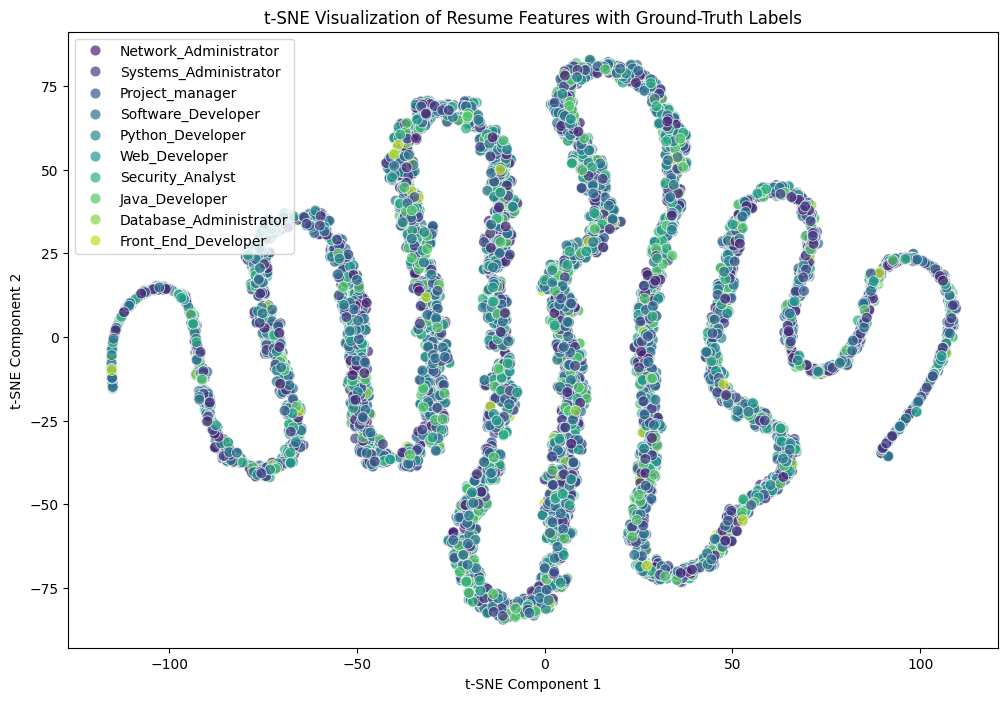

In [ ]:

# Create a scatter plot with adjusted opacity (alpha)
plt.figure(figsize=(12, 8))
sns.scatterplot(
    x=X_tsne[:, 0],
    y=X_tsne[:, 1],
    hue=label_names_sampled,
    palette="viridis",
    legend='full',
    s=60,
    alpha=0.7  # Adjusted opacity
)

# Add axis labels and title
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.title('t-SNE Visualization of Resume Features with Ground-Truth Labels')
plt.legend(loc='best')
plt.show()


In [ ]:
import numpy as np
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_selection import mutual_info_classif
import matplotlib.pyplot as plt
import nltk
import re


In [ ]:
labels_v2 = []

zip_path = '/content/drive/MyDrive/resumes_corpus.zip'

try:
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        # List and sort all .lab files to match the order of resumes
        all_files = zip_ref.namelist()
        lab_files = sorted([f for f in all_files if f.lower().endswith('.lab')])

        if not lab_files:
            print("No .lab files found in the zip archive.")
        else:
            print(f"Found {len(lab_files)} .lab files.")

            for lab_file in lab_files:
                with zip_ref.open(lab_file) as file:
                    lab_bytes = file.read()
                    encoding = detect_encoding(lab_bytes)
                    try:
                        lab_content = lab_bytes.decode(encoding).strip()
                    except UnicodeDecodeError:
                        lab_content = lab_bytes.decode('utf-8', errors='replace').strip()

                    if lab_content:
                        # Collect labels for this resume
                        labels_in_file = [label.strip() for label in lab_content.split('\n') if label.strip()]
                        labels_v2.append(labels_in_file)
                    else:
                        # Append an empty list if no labels
                        labels_v2.append([])
except Exception as e:
    print(f"An error occurred: {e}")



Found 29783 .lab files.


In [ ]:
print("Number of resumes:", len(resumes))       # Should be 29,783
print("Number of label sets:", len(labels_v2))     # Should also be 29,783
print("First 5 label sets:", labels_v2[:5])        # View the first few entries


Number of resumes: 29783
Number of label sets: 29783
First 5 label sets: [['Database_Administrator'], ['Database_Administrator'], ['Database_Administrator'], ['Database_Administrator'], ['Database_Administrator']]


In [ ]:
from sklearn.preprocessing import MultiLabelBinarizer

mlb = MultiLabelBinarizer()
y_binary = mlb.fit_transform(labels_v2)

print("Shape of X:", X.shape)
print("Shape of y_binary:", y_binary.shape)


Shape of X: (29783, 14)
Shape of y_binary: (29783, 10)


In [ ]:
import pandas as pd
from sklearn.feature_selection import mutual_info_classif

from sklearn.feature_selection import chi2

mi_df = pd.DataFrame()
feature_names = vectorizer.get_feature_names_out()

for i in range(y_binary.shape[1]):
    chi2_vals, p_vals = chi2(X, y_binary[:, i])
    chi2_series = pd.Series(chi2_vals, index=feature_names, name=mlb.classes_[i])
    mi_df = pd.concat([mi_df, chi2_series], axis=1)

# Compute average mutual information across all labels
mi_df['Average_MI'] = mi_df.mean(axis=1)
mi_df.sort_values('Average_MI', ascending=False, inplace=True)

# Display top features
print("Top 20 features ranked by average mutual information:")
print(mi_df['Average_MI'].head(20))

# Plotting
import matplotlib.pyplot as plt

mi_df['Average_MI'].head(20).plot.bar(figsize=(12, 6))
plt.title('Top 20 Features Ranked by Average Mutual Information')
plt.ylabel('Average Mutual Information')
plt.xlabel('Features')
plt.show()


NotFittedError: Vocabulary not fitted or provided

Top 20 features ranked by average chi-squared score:
python           821.449511
network          544.037132
security         528.408892
django           506.204893
spring           493.504310
web              399.158665
java             362.303448
front            351.742578
administrator    333.469088
developer        331.871542
database         325.417455
javascript       253.728203
hibernate        252.440320
js               246.805968
cisco            232.164656
project          218.058233
using            212.348415
jquery           208.853114
j2ee             208.802385
css              199.367967
Name: Average_Chi2, dtype: float64


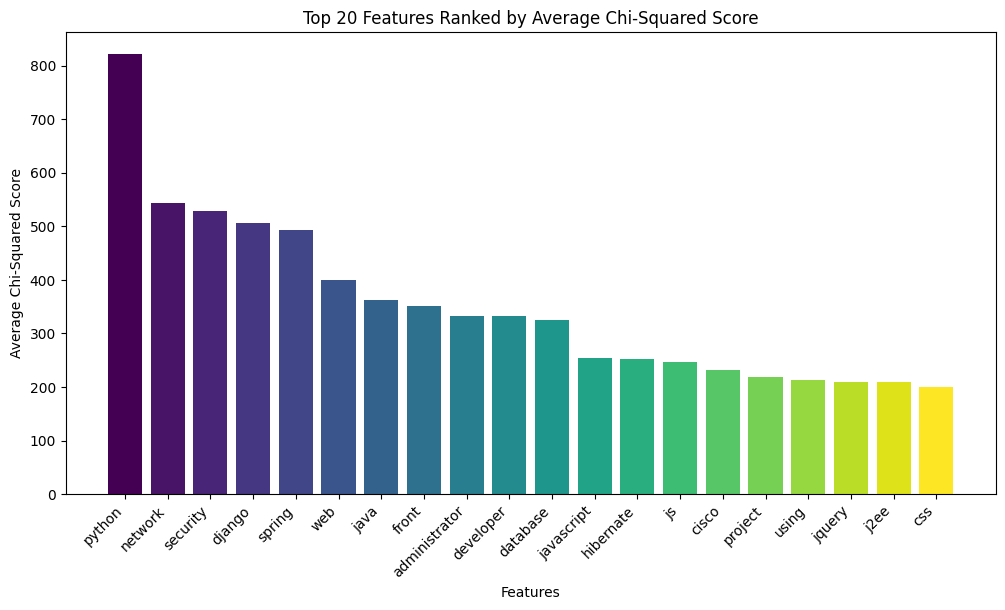

In [ ]:
import pandas as pd
from sklearn.feature_selection import chi2

# Initialize an empty DataFrame to store chi-squared scores
chi2_df = pd.DataFrame()
feature_names = vectorizer.get_feature_names_out()

# Compute chi-squared scores for each label
for i in range(y_binary.shape[1]):
    chi2_vals, p_vals = chi2(X, y_binary[:, i])
    chi2_series = pd.Series(chi2_vals, index=feature_names, name=mlb.classes_[i])
    chi2_df = pd.concat([chi2_df, chi2_series], axis=1)

# Compute average chi-squared score across all labels
chi2_df['Average_Chi2'] = chi2_df.mean(axis=1)
chi2_df.sort_values('Average_Chi2', ascending=False, inplace=True)

# Display top features
print("Top 20 features ranked by average chi-squared score:")
print(chi2_df['Average_Chi2'].head(20))


top_features = chi2_df['Average_Chi2'].head(20)
top_features = top_features.sort_values(ascending=False)
cmap = plt.cm.viridis
colors = cmap(np.linspace(0, 1, len(top_features)))

plt.figure(figsize=(12, 6))
plt.bar(top_features.index, top_features.values, color=colors)
plt.title('Top 20 Features Ranked by Average Chi-Squared Score')
plt.ylabel('Average Chi-Squared Score')
plt.xlabel('Features')
plt.xticks(rotation=45, ha='right')
plt.show()


In [ ]:
# List of labels
labels_list = mlb.classes_
print("Target Labels:", labels_list)


Target Labels: ['Database_Administrator' 'Front_End_Developer' 'Java_Developer'
 'Network_Administrator' 'Project_manager' 'Python_Developer'
 'Security_Analyst' 'Software_Developer' 'Systems_Administrator'
 'Web_Developer']


In [ ]:
label_name = 'Database_Administrator'  # Replace with your actual label
chi2_scores_label = chi2_df[label_name]
top_features_label = chi2_scores_label.sort_values(ascending=False).head(20)
print(f"Top 20 features for label '{label_name}' by chi-squared score:")
print(top_features_label)


Top 20 features for label 'Database_Administrator' by chi-squared score:
database         2710.941361
oracle           1351.764281
databases         927.083479
tuning            910.948794
sql               831.118688
11g               632.676633
recovery          388.148998
backup            316.633117
performance       248.288770
administrator     207.104450
production        150.673952
server            130.251211
data              118.543698
web               113.254556
tables            102.169227
monitoring         90.136051
python             87.568938
developer          73.636458
js                 72.780711
network            72.312077
Name: Database_Administrator, dtype: float64


<ipython-input-43-218e2e42025b>:31: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[idx].set_xticklabels(top_features_label.index, rotation=45, ha='right')


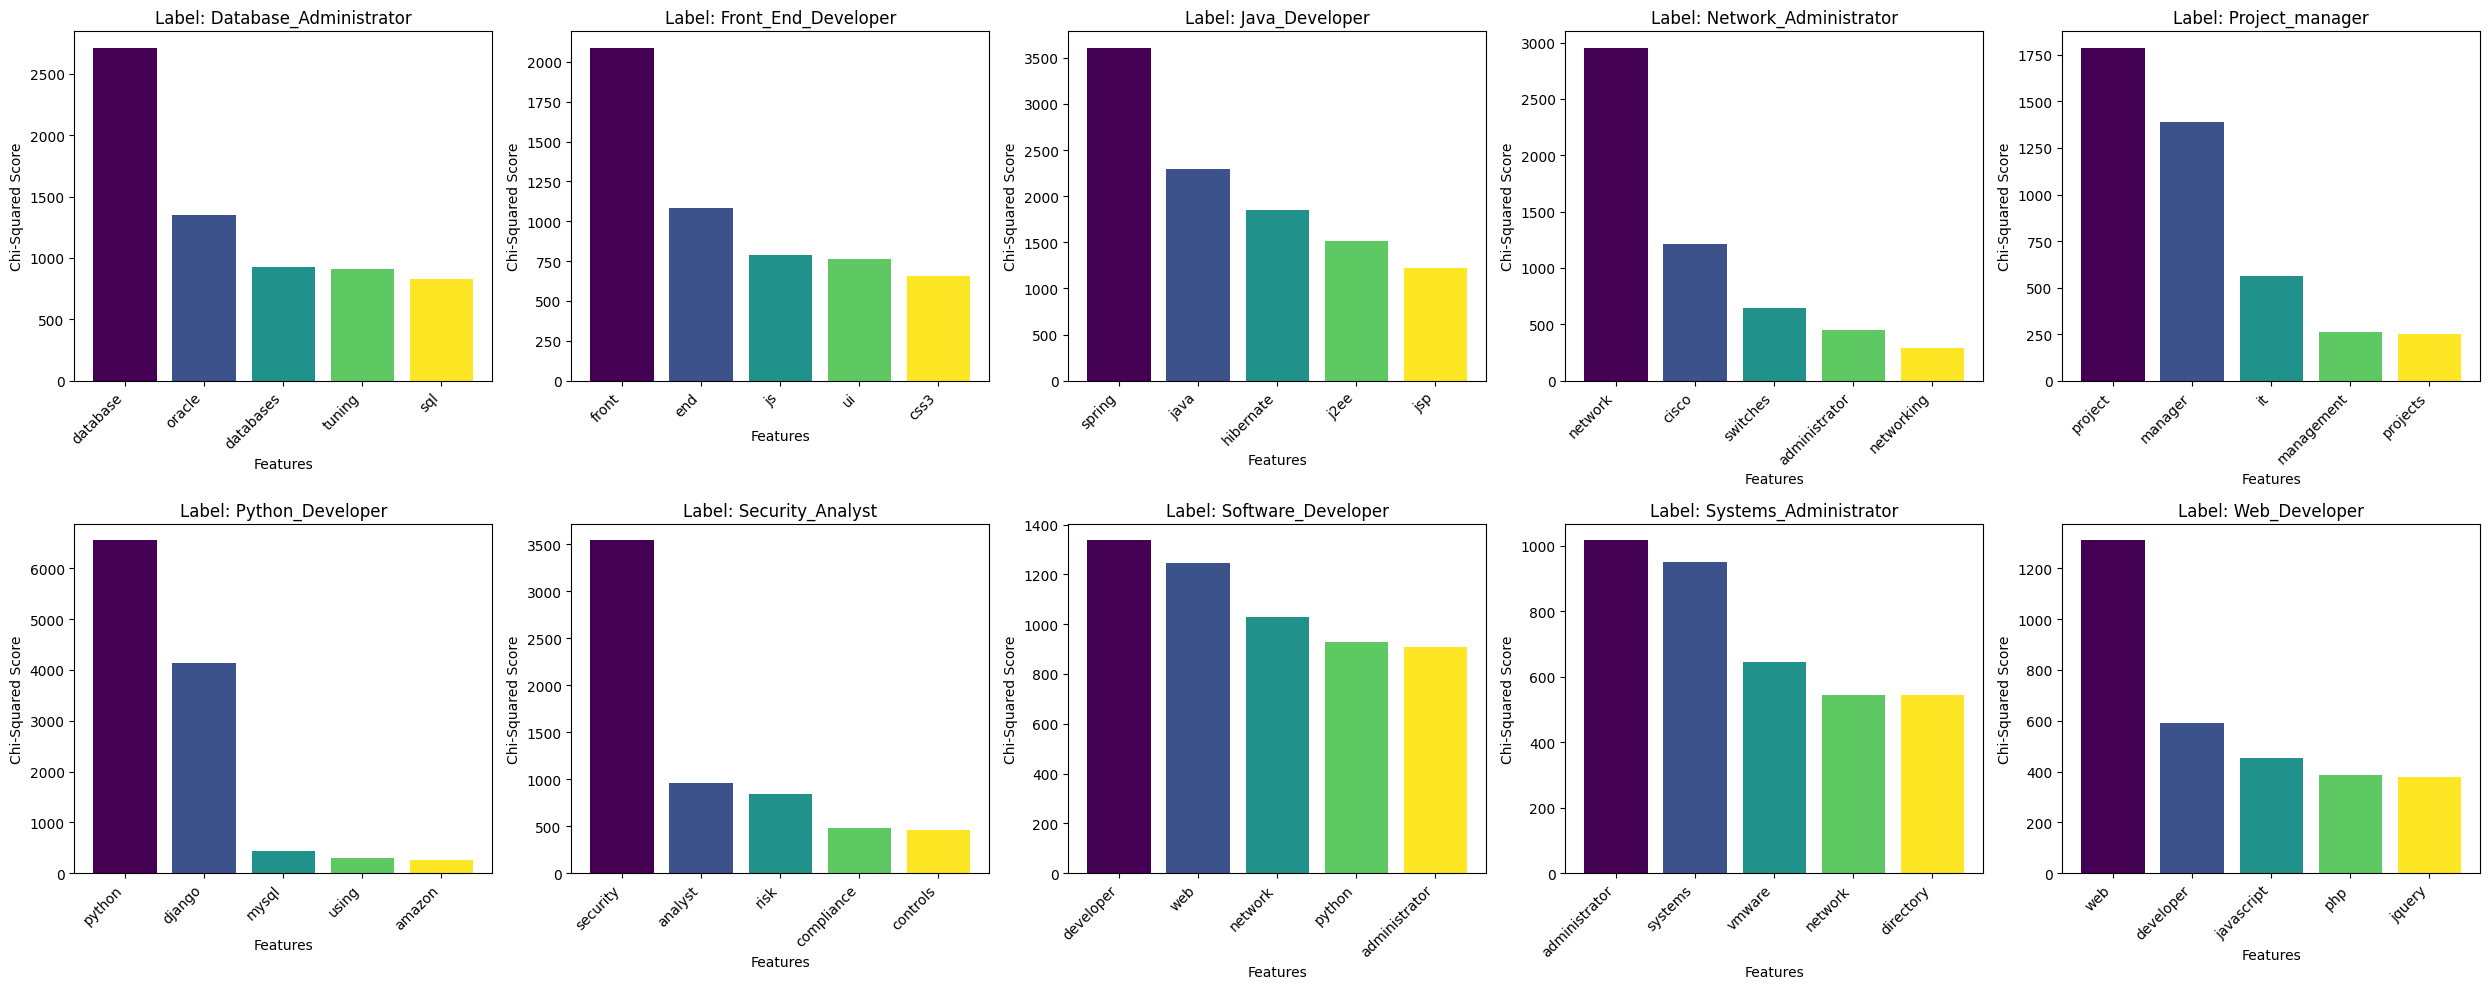

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Define the number of labels and features you want to plot
num_labels = 10  # Number of labels to plot
num_features = 5  # Number of top features per label

# Get the list of labels
labels_list = mlb.classes_[:num_labels]  # Ensure you have at least num_labels labels

# Create subplots
fig, axes = plt.subplots(nrows=2, ncols=5, figsize=(25, 10), sharey=False)
axes = axes.flatten()  # Flatten the array of axes for easy iteration

# Loop over the labels and plot top features
for idx, label_name in enumerate(labels_list):
    chi2_scores_label = chi2_df[label_name]
    top_features_label = chi2_scores_label.sort_values(ascending=False).head(num_features)

    # Generate colors using the viridis colormap
    cmap = plt.cm.viridis
    colors = cmap(np.linspace(0, 1, num_features))

    # Plotting
    axes[idx].bar(top_features_label.index, top_features_label.values, color=colors)
    axes[idx].set_title(f"Label: {label_name}", fontsize=12)
    axes[idx].set_ylabel('Chi-Squared Score', fontsize=10)
    axes[idx].set_xlabel('Features', fontsize=10)
    axes[idx].tick_params(axis='x', rotation=45)
    axes[idx].set_xticklabels(top_features_label.index, rotation=45, ha='right')

# Hide any unused subplots if there are fewer labels than subplots
if len(labels_list) < len(axes):
    for idx in range(len(labels_list), len(axes)):
        fig.delaxes(axes[idx])

plt.tight_layout()
plt.show()


/usr/local/lib/python3.10/dist-packages/sklearn/manifold/_t_sne.py:1162: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


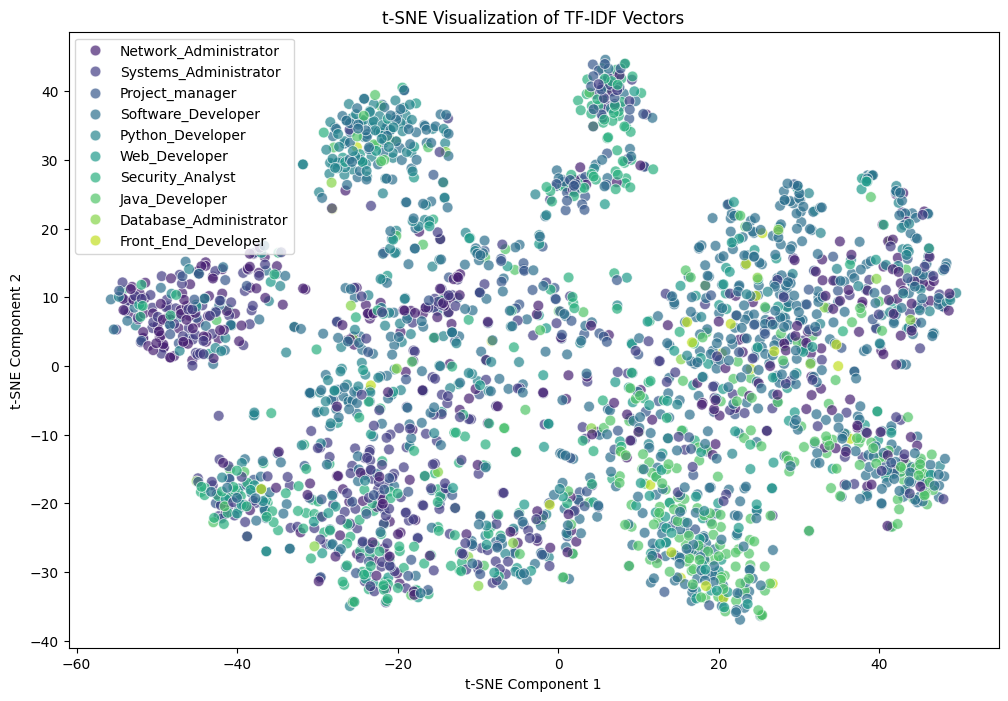

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

# Assuming 'resume_df' is your DataFrame with a column 'resume_text'
# and 'labels' is your labels array or Series

# Step 1: Compute TF-IDF Vectors
vectorizer = TfidfVectorizer(max_features=100)  # Adjust max_features as needed
tfidf_matrix = vectorizer.fit_transform(resumes)

# Convert TF-IDF matrix to dense format
tfidf_matrix_dense = tfidf_matrix.toarray()

# Step 2: Sampling (adjust sample_size based on your computational resources)
sample_size = 2500  # Reduce if you encounter memory issues

if tfidf_matrix_dense.shape[0] > sample_size:
    np.random.seed(42)
    sampled_indices = np.random.choice(tfidf_matrix_dense.shape[0], sample_size, replace=False)
    tfidf_sampled = tfidf_matrix_dense[sampled_indices]
    label_names_sampled = labels.iloc[sampled_indices] if isinstance(labels, pd.Series) else np.array(labels)[sampled_indices]
else:
    tfidf_sampled = tfidf_matrix_dense
    label_names_sampled = labels

# Step 3: Apply PCA before t-SNE (optional but recommended for high-dimensional data)
pca = PCA(n_components=50, random_state=42)  # Reduce to 50 components
tfidf_pca = pca.fit_transform(tfidf_sampled)

# Step 4: Apply t-SNE
tsne = TSNE(n_components=2, random_state=42, perplexity=30, n_iter=1000)
X_tsne = tsne.fit_transform(tfidf_pca)

# Step 5: Create a scatter plot with adjusted opacity (alpha)
plt.figure(figsize=(12, 8))
sns.scatterplot(
    x=X_tsne[:, 0],
    y=X_tsne[:, 1],
    hue=label_names_sampled,
    palette="viridis",
    legend='full',
    s=60,
    alpha=0.7  # Adjusted opacity
)

# Add axis labels and title
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.title('t-SNE Visualization of TF-IDF Vectors')
plt.legend(loc='best')
plt.show()


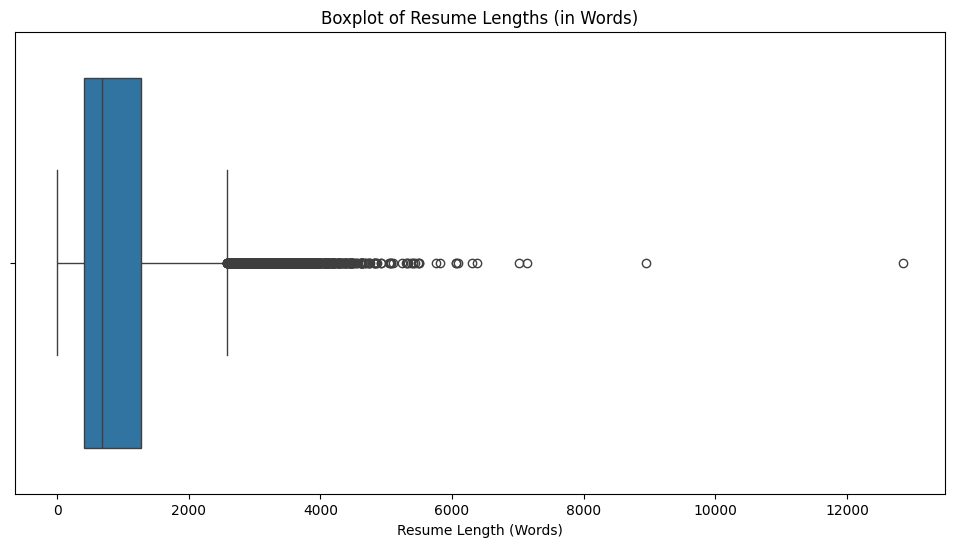

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Create a boxplot for resume lengths
plt.figure(figsize=(12, 6))
sns.boxplot(x=lengths)
plt.title('Boxplot of Resume Lengths (in Words)')
plt.xlabel('Resume Length (Words)')
plt.show()


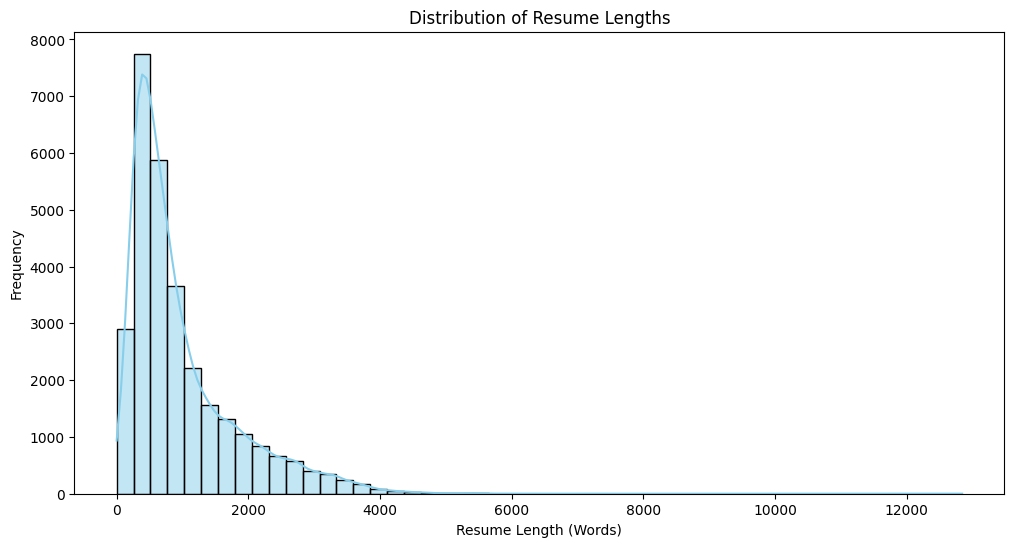

In [ ]:
# Create a histogram and KDE plot for resume lengths
plt.figure(figsize=(12, 6))
sns.histplot(lengths, bins=50, kde=True, color='skyblue')
plt.title('Distribution of Resume Lengths')
plt.xlabel('Resume Length (Words)')
plt.ylabel('Frequency')
plt.show()


# Pre-processing & Feature engineering

In [ ]:
import zipfile
import os
import pandas as pd
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.model_selection import train_test_split

# Ensure NLTK data is downloaded
nltk.download('stopwords')
nltk.download('wordnet')

def detect_encoding(byte_data):
    import chardet
    result = chardet.detect(byte_data)
    return result['encoding'] if result['encoding'] else 'utf-8'

def preprocess_text(text):
    lemmatizer = WordNetLemmatizer()
    stop_words = set(stopwords.words('english'))

    text = text.lower()
    text = re.sub(r'[^a-z\s]', '', text)
    tokens = text.split()
    tokens = [lemmatizer.lemmatize(word) for word in tokens if word not in stop_words]
    return ' '.join(tokens)

# Initialize lists to store resumes and labels
resumes = []
labels = []

# Path to your ZIP file
zip_path = '/content/drive/MyDrive/resumes_corpus.zip'

try:
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        # List all files in the ZIP archive
        all_files = zip_ref.namelist()

        # Filter out resume (.txt) and label (.lab) files
        resume_files = [f for f in all_files if f.lower().endswith('.txt')]
        label_files = [f for f in all_files if f.lower().endswith('.lab')]

        if not resume_files:
            print("No .txt resume files found in the zip archive.")
        if not label_files:
            print("No .lab label files found in the zip archive.")

        if not resume_files or not label_files:
            print("Ensure that both .txt and .lab files are present in the ZIP archive.")
        else:
            print(f"Found {len(resume_files)} resume files and {len(label_files)} label files.")

            # Creating mapping from base filename to label filename
            label_mapping = {os.path.splitext(os.path.basename(f))[0]: f for f in label_files}

            for resume_file in resume_files:
                base_name = os.path.splitext(os.path.basename(resume_file))[0]
                corresponding_label_file = label_mapping.get(base_name)

                if not corresponding_label_file:
                    print(f"No corresponding .lab file found for resume: {resume_file}. Skipping.")
                    continue

                # Read and decode resume content
                with zip_ref.open(resume_file) as file:
                    resume_bytes = file.read()
                    encoding = detect_encoding(resume_bytes)
                    try:
                        resume_content = resume_bytes.decode(encoding).strip()
                    except UnicodeDecodeError:
                        # Fallback to 'utf-8' with replacement if decoding fails
                        resume_content = resume_bytes.decode('utf-8', errors='replace').strip()

                    if resume_content:
                        # Text Preprocessing
                        resume_content = preprocess_text(resume_content)
                        resumes.append(resume_content)
                    else:
                        print(f"Resume file {resume_file} is empty. Skipping.")
                        continue  # Skip if resume content is empty

                # Read and decode label content
                with zip_ref.open(corresponding_label_file) as file:
                    lab_bytes = file.read()
                    encoding = detect_encoding(lab_bytes)
                    try:
                        lab_content = lab_bytes.decode(encoding).strip()
                    except UnicodeDecodeError:
                        # Fallback to 'utf-8' with replacement if decoding fails
                        lab_content = lab_bytes.decode('utf-8', errors='replace').strip()

                    if lab_content:
                        # Assuming each .lab file contains a single label
                        labels.append(lab_content)
                    else:
                        print(f"Label file {corresponding_label_file} is empty. Skipping.")
                        # Optionally, append a default label or handle as needed
                        labels.append(None)  # or some default value

    # After processing, verify that resumes and labels have the same length
    if len(resumes) != len(labels):
        print("Mismatch between number of resumes and labels.")
        print(f"Number of resumes: {len(resumes)}, Number of labels: {len(labels)}")
    else:
        print(f"Successfully processed {len(resumes)} resumes and labels.")

except FileNotFoundError:
    print(f"The file {zip_path} does not exist. Please check the path.")
except zipfile.BadZipFile:
    print(f"The file {zip_path} is not a zip file or it is corrupted.")
except Exception as e:
    print(f"An unexpected error occurred: {e}")

# Create DataFrame only if resumes and labels have the same length
if len(resumes) == len(labels):
    data = pd.DataFrame({
        'resume': resumes,
        'label': labels
    })
else:
    # Optionally, handle the mismatch by aligning or removing entries
    # For simplicity, let's drop entries with None labels
    print("Dropping entries with missing labels.")
    data = pd.DataFrame({
        'resume': resumes,
        'label': labels
    }).dropna(subset=['label'])

    print(f"DataFrame created with {data.shape[0]} entries after dropping missing labels.")

# Reset index
data.reset_index(drop=True, inplace=True)


Label file 00142.lab is empty. Skipping.
Label file 00157.lab is empty. Skipping.
Label file 00276.lab is empty. Skipping.
Label file 00323.lab is empty. Skipping.
Label file 00329.lab is empty. Skipping.
Label file 00342.lab is empty. Skipping.
Label file 00358.lab is empty. Skipping.
Label file 00433.lab is empty. Skipping.
Label file 00435.lab is empty. Skipping.
Label file 00465.lab is empty. Skipping.
Label file 00499.lab is empty. Skipping.
Label file 00506.lab is empty. Skipping.
Label file 00511.lab is empty. Skipping.
Label file 00539.lab is empty. Skipping.
Label file 00579.lab is empty. Skipping.
Label file 00589.lab is empty. Skipping.
Label file 00592.lab is empty. Skipping.
Label file 00598.lab is empty. Skipping.
Label file 00617.lab is empty. Skipping.
Label file 00646.lab is empty. Skipping.
Label file 00670.lab is empty. Skipping.
Label file 00699.lab is empty. Skipping.
Label file 00740.lab is empty. Skipping.
Label file 00743.lab is empty. Skipping.
Label file 00744

In [ ]:
# data['resume'].info()
# data['label'].info()
# Check the number of missing labels
missing_labels = data['label'].isnull().sum()
print(f"Number of missing labels: {missing_labels}")

# Drop rows with missing labels
data_cleaned = data.dropna(subset=['label']).reset_index(drop=True)

print(f"DataFrame after dropping missing labels has {data_cleaned.shape[0]} entries.")


Number of missing labels: 748
DataFrame after dropping missing labels has 29035 entries.


In [ ]:
data_cleaned['label_list'] = data_cleaned['label'].apply(lambda x: x.split('\n'))
data_cleaned['primary_label'] = data_cleaned['label_list'].apply(lambda x: x[0] if isinstance(x, list) and len(x) > 0 else None)


In [ ]:
data_cleaned.info()
# Verify lengths
assert len(data_cleaned['resume']) == len(data_cleaned['label']), "Mismatch between resumes and labels after cleaning."

# Verify no missing labels
assert data_cleaned['label'].isnull().sum() == 0, "There are still missing labels."

assert data_cleaned['label_list'].isnull().sum() == 0, "There are still missing labels."

print("Data integrity verified: resumes and labels are aligned with no missing values.")


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 29035 entries, 0 to 29034
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   resume         29035 non-null  object
 1   label          29035 non-null  object
 2   label_list     29035 non-null  object
 3   primary_label  29035 non-null  object
dtypes: object(4)
memory usage: 907.5+ KB
Data integrity verified: resumes and labels are aligned with no missing values.


In [ ]:
import pandas as pd

# Assuming 'data_cleaned' is your cleaned DataFrame
class_counts = data_cleaned['primary_label'].value_counts()
print("Class Distribution:\n", class_counts)


Class Distribution:
 primary_label
Software_Developer        5828
Systems_Administrator     4182
Project_manager           3527
Web_Developer             3466
Database_Administrator    2784
Java_Developer            2418
Python_Developer          2311
Network_Administrator     2260
Security_Analyst          2259
Name: count, dtype: int64


In [ ]:
from sklearn.model_selection import train_test_split

# Perform the train-test split using 'data_cleaned['label']' for stratification
X_train, X_temp, y_train, y_temp = train_test_split(
    data_cleaned['resume'],
    data_cleaned['primary_label'],
    test_size=0.4, # perhaps adjust this
    random_state=42,
    stratify=data_cleaned['primary_label']  # Use the 'label' column from the cleaned DataFrame
)

# Further split the temporary set into validation and test sets
X_val, X_test, y_val, y_test = train_test_split(
    X_temp,
    y_temp,
    test_size=0.5,  # 20% validation and 20% test
    random_state=42,
    stratify=y_temp # Stratifying the labels
)

total = X_train.shape[0] + X_val.shape[0] + X_test.shape[0]

# Verify the splits
print(f"Training set: {X_train.shape[0]} samples")
print(f"Training percentage: {(X_train.shape[0])/total*100}")
print(f"Validation set: {X_val.shape[0]} samples")
print(f"Validation percentage: {(X_val.shape[0])/total*100}")
print(f"Test set: {X_test.shape[0]} samples")
print(f"Test percentage: {(X_test.shape[0])/total*100}")

print(f"Total: {total} samples")
# Verify label distribution
print("\nLabel distribution in Training Set:")
print(y_train.value_counts(normalize=True))

print("\nLabel distribution in Validation Set:")
print(y_val.value_counts(normalize=True))

print("\nLabel distribution in Test Set:")
print(y_test.value_counts(normalize=True))


Training set: 20324 samples
Validation set: 4355 samples
Test set: 4356 samples

Label distribution in Training Set:
primary_label
Software_Developer        0.200699
Systems_Administrator     0.144017
Project_manager           0.121482
Web_Developer             0.119366
Database_Administrator    0.095896
Java_Developer            0.083301
Python_Developer          0.079610
Network_Administrator     0.077839
Security_Analyst          0.077790
Name: proportion, dtype: float64

Label distribution in Validation Set:
primary_label
Software_Developer        0.200689
Systems_Administrator     0.143972
Project_manager           0.121470
Web_Developer             0.119403
Database_Administrator    0.095752
Java_Developer            0.083352
Python_Developer          0.079679
Security_Analyst          0.077842
Network_Administrator     0.077842
Name: proportion, dtype: float64

Label distribution in Test Set:
primary_label
Software_Developer        0.200872
Systems_Administrator     0.144169
Pro

# Checkpoint 2

In [ ]:
import pickle
import os

checkpoint_dir = '/content/drive/MyDrive/checkpoints'
os.makedirs(checkpoint_dir, exist_ok=True)

# X_val, X_test, y_val, y_test
checkpoint2 = {
    'X_train': X_train,
    'y_train': y_train,
    'X_val': X_val,
    'X_test': X_test,
    'y_val': y_val,
    'y_test': y_test,
    'data_cleaned': data_cleaned
}


checkpoint_path = os.path.join(checkpoint_dir, 'checkpoint2.pkl')
with open(checkpoint_path, 'wb') as f:
    pickle.dump(checkpoint2, f)

print("Checkpoint 2 saved successfully ")

Checkpoint 2 saved successfully 


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import zipfile
import matplotlib.gridspec as gridspec
import re
from sklearn.feature_extraction.text import TfidfVectorizer
import nltk
import chardet
from nltk import pos_tag, word_tokenize
from nltk.corpus import stopwords
from collections import Counter
import pickle as pkl
from google.colab import drive

nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('stopwords')
drive.mount('/content/drive')


with open('/content/drive/MyDrive/checkpoints/checkpoint2.pkl', 'rb') as f:
    checkpoint2 = pkl.load(f)

# Accessing variables
X_train = checkpoint2['X_train']
y_train = checkpoint2['y_train']
X_val = checkpoint2['X_val']
X_test = checkpoint2['X_test']
y_val = checkpoint2['y_val']
y_test = checkpoint2['y_test']
data_cleaned = checkpoint2['data_cleaned']

print("Checkpoint loaded successfully")


total = X_train.shape[0] + X_val.shape[0] + X_test.shape[0]
# Verify the splits
print(f"Training percentage: {(X_train.shape[0])/total*100}")
print(f"Validation percentage: {(X_val.shape[0])/total*100}")
print(f"Test percentage: {(X_test.shape[0])/total*100}")

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Checkpoint loaded successfully
Training percentage: 60.0
Validation percentage: 20.0
Test percentage: 20.0


# KNN

## KNN-classifier based on TF-IDF

### KNN prediction on primary label

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, accuracy_score, f1_score, cohen_kappa_score
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer

# Pipeline with TF-IDF KNN classifier
knn_pipeline = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('knn', KNeighborsClassifier())
])

# Training the model
knn_pipeline.fit(X_train, y_train)

# Making predictions on validation set
y_pred_val = knn_pipeline.predict(X_val)

# Evaluating the model on validation set
print("KNN Classification Report (Validation Set):")
print(classification_report(y_val, y_pred_val))
print(f"KNN Accuracy (Validation Set): {accuracy_score(y_val, y_pred_val):.4f}")
print(f"KNN Cohen's kappa (Validation Set): {cohen_kappa_score(y_val, y_pred_val):.4f}")
print(f"KNN F1-score (Validation Set): {f1_score(y_val, y_pred_val, average='weighted'):.4f}")



KNN Classification Report (Validation Set):
                        precision    recall  f1-score   support

Database_Administrator       0.76      0.74      0.75       557
        Java_Developer       0.73      0.89      0.80       483
 Network_Administrator       0.56      0.58      0.57       452
       Project_manager       0.70      0.71      0.70       706
      Python_Developer       0.76      0.85      0.80       462
      Security_Analyst       0.74      0.76      0.75       452
    Software_Developer       0.65      0.53      0.58      1165
 Systems_Administrator       0.65      0.68      0.67       837
         Web_Developer       0.52      0.50      0.51       693

              accuracy                           0.67      5807
             macro avg       0.67      0.69      0.68      5807
          weighted avg       0.67      0.67      0.66      5807

SVC Accuracy (Validation Set): 0.6685
KNN Cohen's kappa (Validation Set): 0.6230
KNN F1-score (Validation Set): 0.6649


# SVC

## Support Vector Classifier
Although not included in thesis proposal, will include it for now as it achieved a decent F1-score.

In [ ]:
from sklearn.svm import SVC
from sklearn.metrics import classification_report, accuracy_score, f1_score, cohen_kappa_score
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer

SVC_pipeline = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('SVC', SVC())
])

SVC_pipeline.fit(X_train, y_train)
y_pred_val_SVC = SVC_pipeline.predict(X_val)

print("SVC Classification Report (Validation Set):")
print(classification_report(y_val, y_pred_val_SVC))
print(f"SVC Cohen's kappa (Validation Set): {cohen_kappa_score(y_val, y_pred_val_SVC):.4f}")
print(f"SVC F1-score (Validation Set): {f1_score(y_val, y_pred_val_SVC, average='weighted'):.4f}")


SVC Classification Report (Validation Set):
                        precision    recall  f1-score   support

Database_Administrator       0.91      0.87      0.89       557
        Java_Developer       0.88      0.87      0.88       483
 Network_Administrator       0.83      0.70      0.76       452
       Project_manager       0.87      0.86      0.87       706
      Python_Developer       0.89      0.86      0.88       462
      Security_Analyst       0.84      0.85      0.84       452
    Software_Developer       0.76      0.84      0.80      1165
 Systems_Administrator       0.79      0.86      0.82       837
         Web_Developer       0.80      0.72      0.76       693

              accuracy                           0.83      5807
             macro avg       0.84      0.82      0.83      5807
          weighted avg       0.83      0.83      0.83      5807

SVC Cohen's kappa (Validation Set): 0.8015
SVC F1-score (Validation Set): 0.8266


In [ ]:
import pandas as pd
from surprise import SVDpp, Dataset, Reader
from surprise.model_selection import train_test_split
from surprise import accuracy


In [ ]:
data_cleaned

,resume,label,label_list,primary_label
0,database administrator span classhldatabasespa...,Database_Administrator,[Database_Administrator],Database_Administrator
1,database administrator span classhldatabasespa...,Database_Administrator,[Database_Administrator],Database_Administrator
2,oracle database administrator oracle span clas...,Database_Administrator,[Database_Administrator],Database_Administrator
3,amazon redshift administrator etl developer bu...,Database_Administrator,[Database_Administrator],Database_Administrator
4,scrum master scrum master scrum master richmon...,Database_Administrator,[Database_Administrator],Database_Administrator
...,...,...,...,...
29030,servicenow developer servicenow span classhlde...,Java_Developer\nWeb_Developer\nSoftware_Developer,"[Java_Developer, Web_Developer, Software_Devel...",Java_Developer
29031,android developer android span classhldevelope...,Web_Developer\nSoftware_Developer,"[Web_Developer, Software_Developer]",Web_Developer
29032,ui developer ui span classhldeveloperspan ui d...,Software_Developer\nFront_End_Developer\nWeb_D...,"[Software_Developer, Front_End_Developer, Web_...",Software_Developer
29033,web developer span classhlwebspan span classhl...,Web_Developer\nSoftware_Developer,"[Web_Developer, Software_Developer]",Web_Developer


# SVD++

## Creating an interaction dataframe

In [ ]:
data_cleaned

,resume,label,label_list,primary_label
0,database administrator span classhldatabasespa...,Database_Administrator,[Database_Administrator],Database_Administrator
1,database administrator span classhldatabasespa...,Database_Administrator,[Database_Administrator],Database_Administrator
2,oracle database administrator oracle span clas...,Database_Administrator,[Database_Administrator],Database_Administrator
3,amazon redshift administrator etl developer bu...,Database_Administrator,[Database_Administrator],Database_Administrator
4,scrum master scrum master scrum master richmon...,Database_Administrator,[Database_Administrator],Database_Administrator
...,...,...,...,...
29030,servicenow developer servicenow span classhlde...,Java_Developer\nWeb_Developer\nSoftware_Developer,"[Java_Developer, Web_Developer, Software_Devel...",Java_Developer
29031,android developer android span classhldevelope...,Web_Developer\nSoftware_Developer,"[Web_Developer, Software_Developer]",Web_Developer
29032,ui developer ui span classhldeveloperspan ui d...,Software_Developer\nFront_End_Developer\nWeb_D...,"[Software_Developer, Front_End_Developer, Web_...",Software_Developer
29033,web developer span classhlwebspan span classhl...,Web_Developer\nSoftware_Developer,"[Web_Developer, Software_Developer]",Web_Developer


Primary label instead of all labels

In [ ]:
import numpy as np

# Get all unique users and items
all_users = data_cleaned.index.astype(str).tolist()
all_items = data_cleaned['primary_label'].unique().tolist()

# Initialize lists for user-item interactions
user_ids = []
item_ids = []
ratings = []

for idx, row in data_cleaned.iterrows():
    user_id = str(idx)  # Using index as user_id
    primary_label = row['primary_label']

    # Assign rating=1 for primary label
    user_ids.append(user_id)
    item_ids.append(primary_label)
    ratings.append(1)

    # Assign rating=0 for all other labels (negative interactions)
    for item in all_items:
        if item != primary_label:
            user_ids.append(user_id)
            item_ids.append(item)
            ratings.append(0)

# Creating the interaction DataFrame
interaction_df = pd.DataFrame({
    'user_id': user_ids,
    'item_id': item_ids,
    'rating': ratings
})

# Display the interaction DataFrame
print(interaction_df.head(15))


   user_id                 item_id  rating
0        0  Database_Administrator       1
1        0   Systems_Administrator       0
2        0         Project_manager       0
3        0      Software_Developer       0
4        0           Web_Developer       0
5        0        Security_Analyst       0
6        0   Network_Administrator       0
7        0          Java_Developer       0
8        0        Python_Developer       0
9        1  Database_Administrator       1
10       1   Systems_Administrator       0
11       1         Project_manager       0
12       1      Software_Developer       0
13       1           Web_Developer       0
14       1        Security_Analyst       0


In [ ]:
import numpy as np

# Get all unique users and items
all_users = data_cleaned.index.astype(str).tolist()
all_items = set(item for sublist in data_cleaned['label_list'] for item in sublist)
# Initialize lists for user-item interactions
user_ids = []
item_ids = []
ratings = []

for idx, row in data_cleaned.iterrows():
    user_id = str(idx)  # Using index as user_id
    user_labels = set(row['label_list'])

    # Assign rating=1 for primary label
    for label in user_labels:
        user_ids.append(user_id)
        item_ids.append(label)
        ratings.append(1)

    # Assign rating=0 for all other labels (negative interactions)
    negative_labels = all_items - user_labels
    for item in negative_labels:
        user_ids.append(user_id)
        item_ids.append(item)
        ratings.append(0)

# Creating the interaction DataFrame
interaction_df = pd.DataFrame({
    'user_id': user_ids,
    'item_id': item_ids,
    'rating': ratings
})

# Display the interaction DataFrame
print(interaction_df.tail(15))


       user_id                 item_id  rating
290335   29033        Security_Analyst       0
290336   29033          Java_Developer       0
290337   29033   Systems_Administrator       0
290338   29033     Front_End_Developer       0
290339   29033   Network_Administrator       0
290340   29034           Web_Developer       1
290341   29034      Software_Developer       1
290342   29034  Database_Administrator       0
290343   29034        Python_Developer       0
290344   29034         Project_manager       0
290345   29034        Security_Analyst       0
290346   29034          Java_Developer       0
290347   29034   Systems_Administrator       0
290348   29034     Front_End_Developer       0
290349   29034   Network_Administrator       0


In [ ]:
!pip install scikit-surprise

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.4/154.4 kB 8.8 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for scikit-surprise: filename=scikit_surprise-1.1.4-cp310-cp310-linux_x86_64.whl size=2357277 sha256=7d398f4ed3db1b186be5b0fad7564bd4aa76a40d197b4253f3a6a6cee67774b1
  Stored in directory: /root/.cache/pip/wheels/4b/3f/df/6acbf0a40397d9bf3ff97f582cc22fb9ce66adde75bc71fd54
Successfully built scikit-surprise


In [ ]:
import pandas as pd
import numpy as np
from surprise import Dataset, Reader, SVD, SVDpp
from surprise.model_selection import train_test_split
from sklearn.metrics import f1_score, classification_report
import random

random.seed(42)

# Data Preparation
print("Initial Interaction DataFrame:")
print(interaction_df.head())

# Splitting the Data
# Filter positive interactions
positive_interactions = interaction_df[interaction_df['rating'] == 1]

# Holding out one interaction per user for testing
test_interactions = positive_interactions.groupby('user_id').sample(n=1, random_state=42)
train_positive = positive_interactions.drop(test_interactions.index)

# All negative interactions are in the training set
train_negative = interaction_df[interaction_df['rating'] == 0]
train_df = pd.concat([train_positive, train_negative]).reset_index(drop=True)

test_df = test_interactions.reset_index(drop=True)

print("\nTraining DataFrame:")
print(train_df.head())

print("\nTesting DataFrame:")
print(test_df.head())

# Loading Data into Surprise
# Define the rating scale (e.g., 0 to 1)
reader = Reader(rating_scale=(0, 1))

# Load the training data
data_train = Dataset.load_from_df(train_df[['user_id', 'item_id', 'rating']], reader)

# Model Training
# Initialize  SVD++ model
model = SVDpp(n_factors=50, n_epochs=20, lr_all=0.005, reg_all=0.02)
# Alternatively SVD
# model = SVD(n_factors=50, n_epochs=20, lr_all=0.005, reg_all=0.02)

# Build the training set
trainset = data_train.build_full_trainset()

# Train the model
model.fit(trainset)

# Making Predictions

# Get the list of all unique items
all_items = interaction_df['item_id'].unique()

# Create a dictionary to map users to their training items
user_train_items = train_df[train_df['rating'] == 1].groupby('user_id')['item_id'].apply(set).to_dict()

# Create a dictionary for the test items
user_test_items = test_df.groupby('user_id')['item_id'].apply(set).to_dict()

# Initialize lists to store true and predicted labels
y_true = []
y_pred = []

for user in user_test_items:
    # Items the user has interacted with in training
    train_items = user_train_items.get(user, set())

    # Items to consider for prediction (excluding training items)
    items_to_predict = set(all_items) - train_items

    # If the user has no training interactions, skip
    if not items_to_predict:
        continue

    # Predict ratings for all candidate items
    predictions = []
    for item in items_to_predict:
        pred = model.predict(user, item).est
        predictions.append((item, pred))

    # Select the item with the highest predicted rating
    top_item, top_score = max(predictions, key=lambda x: x[1])

    # Get the true test item(s) for the user
    true_items = user_test_items[user]

    # Since we hold out one interaction per user, there should be one true item
    true_item = list(true_items)[0]

    # Append to the lists
    y_true.append(1)  # True label is positive for the held-out item
    y_pred.append(1 if top_item in true_items else 0)  # 1 if correct prediction, else 0

# Evaluation

# Compute F1-score
f1 = f1_score(y_true, y_pred)
print(f"\nF1-Score: {f1:.4f}")

# Classification report
report = classification_report(y_true, y_pred, target_names=['Incorrect', 'Correct'])
print("\nClassification Report:")
print(report)

# Displaying some prediction results
results = []
for user in user_test_items:
    # Items the user has interacted with in training
    train_items = user_train_items.get(user, set())

    # Items to consider for prediction (excluding training items)
    items_to_predict = set(all_items) - train_items

    # If the user has no training interactions, skip
    if not items_to_predict:
        continue

    # Predict ratings for all candidate items
    predictions = []
    for item in items_to_predict:
        pred = model.predict(user, item).est
        predictions.append((item, pred))

    # Select the item with the highest predicted rating
    top_item, top_score = max(predictions, key=lambda x: x[1])

    # Get the true test item(s) for the user
    true_items = user_test_items[user]

    # Since holding out one interaction per user, there should be one true item
    true_item = list(true_items)[0]

    # Determine if the prediction is correct
    correct = top_item in true_items

    results.append({
        'user_id': user,
        'true_item_id': true_item,
        'predicted_item_id': top_item,
        'correct_prediction': int(correct)
    })

results_df = pd.DataFrame(results)
print("\nPrediction Results:")
print(results_df)


Initial Interaction DataFrame:
  user_id                 item_id  rating
0       0  Database_Administrator       1
1       0      Software_Developer       0
2       0           Web_Developer       0
3       0         Project_manager       0
4       0        Python_Developer       0

Training DataFrame:
  user_id                 item_id  rating
0      17  Database_Administrator       1
1      19  Database_Administrator       1
2      22  Database_Administrator       1
3      34  Database_Administrator       1
4      45  Database_Administrator       1

Testing DataFrame:
  user_id                 item_id  rating
0       0  Database_Administrator       1
1       1  Database_Administrator       1
2      10  Database_Administrator       1
3     100      Software_Developer       1
4    1000  Database_Administrator       1

F1-Score: 0.4392

Classification Report:
              precision    recall  f1-score   support

   Incorrect       0.00      0.00      0.00         0
     Correct       1.

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))



Prediction Results:
      user_id            true_item_id      predicted_item_id  \
0           0  Database_Administrator     Software_Developer   
1           1  Database_Administrator     Software_Developer   
2          10  Database_Administrator     Software_Developer   
3         100      Software_Developer          Web_Developer   
4        1000  Database_Administrator  Systems_Administrator   
...       ...                     ...                    ...   
29030    9995        Security_Analyst  Systems_Administrator   
29031    9996      Software_Developer     Software_Developer   
29032    9997        Security_Analyst  Systems_Administrator   
29033    9998        Security_Analyst     Software_Developer   
29034    9999   Network_Administrator     Software_Developer   

       correct_prediction  
0                       0  
1                       0  
2                       0  
3                       0  
4                       0  
...                   ...  
29030         

In [ ]:
# Separate positive and negative interactions
positive_interactions = interaction_df[interaction_df['rating'] == 1]
negative_interactions = interaction_df[interaction_df['rating'] == 0]

# Hold out one positive interaction per user for testing
test_interactions = positive_interactions.groupby('user_id').sample(n=1, random_state=42)

# Remove test interactions from the positive interactions
positive_train_interactions = positive_interactions.drop(test_interactions.index)

# Downsample negative interactions to match the number of positive training interactions
negative_sample = negative_interactions.sample(n=len(positive_train_interactions), random_state=42)

# Combine positive interactions with the downsampled negative interactions
train_interactions = pd.concat([positive_train_interactions, negative_sample])

# Shuffle the dataset
train_interactions = train_interactions.sample(frac=1, random_state=42)

# Reset indices
train_df = train_interactions.reset_index(drop=True)
test_df = test_interactions.reset_index(drop=True)


# Sample negative interactions for test set (one per user)
negative_test_interactions = negative_interactions.groupby('user_id').sample(n=1, random_state=42)

# Combine with positive test interactions
test_df = pd.concat([test_df, negative_test_interactions]).reset_index(drop=True)

from surprise import Dataset, Reader, SVDpp

# Define the rating scale (0 to 1)
reader = Reader(rating_scale=(0, 1))

# Load the training data
data_train = Dataset.load_from_df(train_df[['user_id', 'item_id', 'rating']], reader)
trainset = data_train.build_full_trainset()

# Initialize the SVD++ model
model = SVDpp(n_factors=50, n_epochs=20, lr_all=0.005, reg_all=0.02)

# Train the model
model.fit(trainset)

from surprise import accuracy

# Prepare the testset for prediction (user_id, item_id, rating)
testset = list(zip(test_df['user_id'], test_df['item_id'], test_df['rating']))

# Make predictions
predictions = model.test(testset)

# Extract true ratings and estimated ratings
y_true = [int(pred.r_ui) for pred in predictions]
y_scores = [pred.est for pred in predictions]

# Determine optimal threshold
from sklearn.metrics import precision_recall_curve

precision, recall, thresholds = precision_recall_curve(y_true, y_scores)
f1_scores = 2 * (precision * recall) / (precision + recall + 1e-10)
best_threshold_index = f1_scores.argmax()
best_threshold = thresholds[best_threshold_index]

print(f"Optimal Threshold: {best_threshold}")
print(f"Best F1-Score at Optimal Threshold: {f1_scores[best_threshold_index]}")

# Apply threshold to get binary predictions
y_pred = [1 if score >= best_threshold else 0 for score in y_scores]

from sklearn.metrics import f1_score, classification_report

# Compute F1-score
f1 = f1_score(y_true, y_pred)
print(f"\nF1-Score: {f1:.4f}")

# Classification report
report = classification_report(y_true, y_pred, target_names=['No Interaction', 'Interaction'])
print("\nClassification Report:")
print(report)


Optimal Threshold: 0.0
Best F1-Score at Optimal Threshold: 0.6666666666222222

F1-Score: 0.6667

Classification Report:
                precision    recall  f1-score   support

No Interaction       0.00      0.00      0.00     29035
   Interaction       0.50      1.00      0.67     29035

      accuracy                           0.50     58070
     macro avg       0.25      0.50      0.33     58070
  weighted avg       0.25      0.50      0.33     58070



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


## Most recent try

In [ ]:
data_cleaned

,resume,label,label_list,primary_label
0,database administrator span classhldatabasespa...,Database_Administrator,[Database_Administrator],Database_Administrator
1,database administrator span classhldatabasespa...,Database_Administrator,[Database_Administrator],Database_Administrator
2,oracle database administrator oracle span clas...,Database_Administrator,[Database_Administrator],Database_Administrator
3,amazon redshift administrator etl developer bu...,Database_Administrator,[Database_Administrator],Database_Administrator
4,scrum master scrum master scrum master richmon...,Database_Administrator,[Database_Administrator],Database_Administrator
...,...,...,...,...
29030,servicenow developer servicenow span classhlde...,Java_Developer\nWeb_Developer\nSoftware_Developer,"[Java_Developer, Web_Developer, Software_Devel...",Java_Developer
29031,android developer android span classhldevelope...,Web_Developer\nSoftware_Developer,"[Web_Developer, Software_Developer]",Web_Developer
29032,ui developer ui span classhldeveloperspan ui d...,Software_Developer\nFront_End_Developer\nWeb_D...,"[Software_Developer, Front_End_Developer, Web_...",Software_Developer
29033,web developer span classhlwebspan span classhl...,Web_Developer\nSoftware_Developer,"[Web_Developer, Software_Developer]",Web_Developer


In [ ]:
# Import necessary libraries
import pandas as pd
import numpy as np
from surprise import Dataset, Reader, SVDpp
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.metrics import f1_score, precision_score, recall_score
from collections import defaultdict

# Set random seed for reproducibility
np.random.seed(42)

# Step 1: Load and Prepare Your Data
# Load your resumes DataFrame and labels list
resumes = data_cleaned['resume']
labels = data_cleaned['label_list']

# Create a DataFrame with resume IDs and their labels
resume_labels_df = pd.DataFrame({
    'resume_id': resumes.index,
    'labels': labels
})

# Binarize the labels using MultiLabelBinarizer
mlb = MultiLabelBinarizer()
label_matrix = mlb.fit_transform(resume_labels_df['labels'])

# Create interaction DataFrame
interaction_data = pd.DataFrame(
    label_matrix,
    index=resume_labels_df['resume_id'],
    columns=mlb.classes_
).reset_index()

# Melt the DataFrame to long format suitable for Surprise
interaction_df = interaction_data.melt(
    id_vars='resume_id',
    var_name='label',
    value_name='interaction'
)

# Keep only positive interactions
interaction_df = interaction_df[interaction_df['interaction'] == 1]

# Rename columns to 'user_id', 'item_id', 'rating' for Surprise
interaction_df.rename(columns={
    'resume_id': 'user_id',
    'label': 'item_id',
    'interaction': 'rating'
}, inplace=True)

# Print the prepared interaction DataFrame
print("Interaction DataFrame:")
print(interaction_df.head())

# Step 2: Split the Data into Training and Testing Sets
# -----------------------------------------------------

from sklearn.model_selection import train_test_split

# Split interactions into train and test sets
train_df, test_df = train_test_split(
    interaction_df,
    test_size=0.2,
    random_state=42 #,
    # stratify=interaction_df['user_id']
)

# Reset indices
train_df = train_df.reset_index(drop=True)
test_df = test_df.reset_index(drop=True)

# Print the number of interactions
print(f"\nNumber of interactions - Train: {len(train_df)}, Test: {len(test_df)}")

# Step 3: Load Data into Surprise and Train the SVD++ Model
# ---------------------------------------------------------

from surprise import Dataset, Reader, SVDpp

# Define the rating scale
reader = Reader(rating_scale=(1, 1))  # All interactions are positive

# Load the training data
data_train = Dataset.load_from_df(train_df[['user_id', 'item_id', 'rating']], reader)
trainset = data_train.build_full_trainset()

# Initialize and train the SVD++ model
model = SVDpp(
    n_factors=50,
    n_epochs=20,
    lr_all=0.005,
    reg_all=0.02,
    random_state=42
)
model.fit(trainset)

# Step 4: Make Predictions for the Test Set
# -----------------------------------------

# Get all unique resumes and labels
all_resumes = interaction_df['user_id'].unique()
all_labels = interaction_df['item_id'].unique()

# Build a set of labels seen in training for each resume
resume_train_labels = train_df.groupby('user_id')['item_id'].apply(set).to_dict()

# Prepare testset for Surprise
testset = []

for resume in all_resumes:
    known_labels = resume_train_labels.get(resume, set())
    # Labels not seen by the resume in training
    unknown_labels = set(all_labels) - known_labels
    for label in unknown_labels:
        testset.append((resume, label, 0))  # The true rating is unknown

# Make predictions for all (resume, label) pairs not seen in training
predictions = model.test(testset)

# Step 5: Generate Top-N Recommendations for Each Resume
# ------------------------------------------------------

# Collect the predictions in a dictionary
top_n = defaultdict(list)
for uid, iid, true_r, est, _ in predictions:
    top_n[uid].append((iid, est))

# For each resume, get top N labels
N = 5  # You can adjust N based on your needs
predicted_labels = {}
for uid, label_scores in top_n.items():
    # Sort labels based on estimated scores
    label_scores.sort(key=lambda x: x[1], reverse=True)
    predicted_labels[uid] = [label for label, score in label_scores[:N]]

# Step 6: Prepare True Labels for Evaluation
# ------------------------------------------

# Create a dictionary of true labels from the test set
true_labels = test_df.groupby('user_id')['item_id'].apply(list).to_dict()

# Step 7: Evaluate the Model Using Multilabel Metrics
# ---------------------------------------------------


# Get the list of resumes present in the test set
test_resumes = test_df['user_id'].unique()

# Prepare lists for true and predicted labels in binary format
all_labels_list = list(all_labels)
y_true = []
y_pred = []

for resume in test_resumes:
    true = [1 if label in true_labels.get(resume, []) else 0 for label in all_labels_list]
    pred = [1 if label in predicted_labels.get(resume, []) else 0 for label in all_labels_list]
    y_true.append(true)
    y_pred.append(pred)

# Compute evaluation metrics
precision_micro = precision_score(y_true, y_pred, average='micro', zero_division=0)
recall_micro = recall_score(y_true, y_pred, average='micro', zero_division=0)
f1_micro = f1_score(y_true, y_pred, average='micro', zero_division=0)

print("\nEvaluation Metrics:")
print(f"Micro Precision: {precision_micro:.4f}")
print(f"Micro Recall: {recall_micro:.4f}")
print(f"Micro F1-Score: {f1_micro:.4f}")

# Classification report
print("\nClassification Report:")
print(classification_report(y_true, y_pred, target_names=all_labels_list, zero_division=0))

# Step 8: Optional - Detailed Analysis
# -------------------------------------

# Example: Print predicted and true labels for a few resumes in the test set
for idx, resume in enumerate(test_resumes[:5]):  # Adjust the number as needed
    print(f"\nResume ID: {resume}")
    print(f"Predicted Labels: {predicted_labels.get(resume, [])}")
    print(f"True Labels: {true_labels.get(resume, [])}")



# Step 8: Optional - Detailed Analysis
# -------------------------------------

# Example: Print predicted and true labels for a few resumes
for idx, resume in enumerate(all_resumes[:5]):  # Adjust the number to see more or fewer examples
    print(f"\nResume ID: {resume}")
    print(f"Predicted Labels: {predicted_labels.get(resume, [])}")
    print(f"True Labels: {true_labels.get(resume, [])}")

# Step 9: Save or Use the Model for Future Predictions
# ----------------------------------------------------

# If you wish to save the model for later use
import pickle

# Save the model
with open('svdpp_model.pkl', 'wb') as f:
    pickle.dump(model, f)

# Load the model
# with open('svdpp_model.pkl', 'rb') as f:
#     model = pickle.load(f)

# Step 10: Conclusion and Next Steps
# ----------------------------------

# You can now use the trained model to make predictions on new resumes.
# Remember to preprocess new data in the same way as the training data.

# Optional: Incorporate content features or try hybrid approaches for better performance.


Interaction DataFrame:
   user_id                 item_id  rating
0        0  Database_Administrator       1
1        1  Database_Administrator       1
2        2  Database_Administrator       1
3        3  Database_Administrator       1
4        4  Database_Administrator       1

Number of interactions - Train: 42377, Test: 10595

Evaluation Metrics:
Micro Precision: 0.1504
Micro Recall: 0.6664
Micro F1-Score: 0.2454

Classification Report:
                        precision    recall  f1-score   support

Database_Administrator       0.33      0.00      0.00       675
   Front_End_Developer       0.08      0.06      0.07       821
        Java_Developer       0.06      0.01      0.02       644
 Network_Administrator       0.10      1.00      0.18       886
       Project_manager       0.10      1.00      0.18       888
      Python_Developer       0.10      0.80      0.18       548
      Security_Analyst       0.06      1.00      0.12       572
    Software_Developer       0.46      1.

# GCN

In [ ]:
data_cleaned.head()

,resume,label,label_list,primary_label
0,database administrator span classhldatabasespa...,Database_Administrator,[Database_Administrator],Database_Administrator
1,database administrator span classhldatabasespa...,Database_Administrator,[Database_Administrator],Database_Administrator
2,oracle database administrator oracle span clas...,Database_Administrator,[Database_Administrator],Database_Administrator
3,amazon redshift administrator etl developer bu...,Database_Administrator,[Database_Administrator],Database_Administrator
4,scrum master scrum master scrum master richmon...,Database_Administrator,[Database_Administrator],Database_Administrator


In [ ]:
# !pip install torch-scatter
!pip install torch-sparse
# !pip install torch-cluster
# !pip install torch-spline-conv
!pip install torch-geometric

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 210.0/210.0 kB 3.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
ERROR: Operation cancelled by user
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/pip/_internal/cli/base_command.py", line 179, in exc_logging_wrapper
    status = run_func(*args)
  File "/usr/local/lib/python3.10/dist-packages/pip/_internal/cli/req_command.py", line 67, in wrapper
    return func(self, options, args)
  File "/usr/local/lib/python3.10/dist-packages/pip/_internal/commands/install.py", line 423, in run
    _, build_failures = build(
  File "/usr/local/lib/python3.10/dist-packages/pip/_internal/wheel_builder.py", line 319, in build
    wheel_file = _build_one(
  File "/usr/local/lib/python3.10/dist-packages/pip/_internal/wheel_builder.py", line 193, in _build_one
    wheel_path = _build_one_inside_env(
  File "/usr/local/lib/python3.10/dist-packages/pip/_internal/wheel_builder.py", line 240, in _build_one_inside_env

In [ ]:
import torch
import torch.nn.functional as F
from torch_geometric.data import Data
from torch_geometric.nn import GCNConv
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.metrics import classification_report, f1_score
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import StandardScaler
import numpy as np
import pandas as pd

# Label Encoding
# Initialize LabelEncoder
label_encoder = LabelEncoder()
integer_labels = label_encoder.fit_transform(data_cleaned['primary_label'])

# One-Hot Encode the labels
one_hot_encoder = OneHotEncoder(sparse_output=False)
integer_labels_reshaped = integer_labels.reshape(-1, 1)
one_hot_labels = one_hot_encoder.fit_transform(integer_labels_reshaped)

num_classes = one_hot_labels.shape[1]

print("\nClasses:", label_encoder.classes_)
print("One-Hot Encoded Labels:\n", one_hot_labels)

# Feature Extraction with TF-IDF
# Initialize TF-IDF Vectorizer with limited features for simplicity
tfidf_vectorizer = TfidfVectorizer(max_features=20, stop_words='english') # Hyperparameter tuning
tfidf_features = tfidf_vectorizer.fit_transform(data_cleaned['resume'])

print("\nTF-IDF Feature Shape:", tfidf_features.shape)

# Scaling TF-IDF Features
# Initialize StandardScaler
scaler = StandardScaler(with_mean=False)
scaled_tfidf = scaler.fit_transform(tfidf_features).toarray()

print("Scaled TF-IDF Feature Shape:", scaled_tfidf.shape)

# Graph Construction
from scipy.sparse import lil_matrix, csr_matrix

# Number of resumes and job categories
num_resumes = len(data_cleaned['resume'])  # 12
job_labels = label_encoder.classes_        # 9
num_jobs = len(job_labels)                 # 9
total_nodes = num_resumes + num_jobs       # 21

# Create edges: each resume connected to its job category
edges = []
for idx, label in enumerate(data_cleaned['primary_label']):
    resume_node = idx
    job_idx = label_encoder.transform([label])[0]
    job_node = num_resumes + job_idx
    edges.append((resume_node, job_node))
    edges.append((job_node, resume_node))  # Undirected graph

# Convert edge list to tensors
edge_index = torch.tensor(edges, dtype=torch.long).t().contiguous()

print("\nEdge Index:\n", edge_index)
print("\nNumber of Nodes:", total_nodes)
print("Number of Edges:", edge_index.size(1))

# Feature Construction for All Nodes
# One-Hot Encode Job Labels
onehot_encoder = OneHotEncoder(sparse_output=False)
unique_jobs = job_labels.reshape(-1, 1)
job_features = onehot_encoder.fit_transform(unique_jobs)
print("\nJob Features Shape:", job_features.shape)

# Number of TF-IDF features
tfidf_dim = scaled_tfidf.shape[1]

# Calculate padding needed for job features
padding_dim = tfidf_dim - job_features.shape[1]

# Pad job_features with zeros to match TF-IDF dimensions
job_features_padded = np.hstack([job_features, np.zeros((num_jobs, padding_dim))])
print("Padded Job Features Shape:", job_features_padded.shape)

# Combine resume and job features
combined_features = np.vstack([scaled_tfidf, job_features_padded])
print("Combined Features Shape:", combined_features.shape)

# Creating the PyG Data Object with Train, Validation, and Test Splits
# Create node features tensor
x = torch.tensor(combined_features, dtype=torch.float)

# Create labels tensor
# Assign job nodes a label of -1 to indicate they are not to be classified
labels = torch.tensor(
    np.concatenate([integer_labels, [-1]*num_jobs]),
    dtype=torch.long
)

print("\nLabels:", labels)
print("Labels Shape:", labels.shape)

# Create masks for train, validation, and test
# Initialize all masks as False
train_mask = torch.zeros(total_nodes, dtype=torch.bool)
val_mask = torch.zeros(total_nodes, dtype=torch.bool)
test_mask = torch.zeros(total_nodes, dtype=torch.bool)

# Define indices for train, val, test
# Shuffle the resume indices
np.random.seed(42)
resume_indices = np.arange(num_resumes)
np.random.shuffle(resume_indices)

'''TODO: Still need to adjust the proportions'''
# Assign 60% for training, 20% for validation, 20% for testing
train_size = int(0.6 * num_resumes)
val_size = int(0.2 * num_resumes)
test_size = num_resumes - train_size - val_size

train_indices = resume_indices[:train_size]
val_indices = resume_indices[train_size:train_size + val_size]
test_indices = resume_indices[train_size + val_size:]

# Setting masks
train_mask[train_indices] = True
val_mask[val_indices] = True
test_mask[test_indices] = True

print("\nTrain Indices:", train_indices)
print("Validation Indices:", val_indices)
print("Test Indices:", test_indices)

# Create the PyG data object with masks
data = Data(
    x=x,
    edge_index=edge_index,
    y=labels,
    train_mask=train_mask,
    val_mask=val_mask,
    test_mask=test_mask
)

print("\nPyG Data Object with Masks:")
print(data)

# Building a Simple GCN Model
class GCN(torch.nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(GCN, self).__init__()
        self.conv1 = GCNConv(input_dim, hidden_dim)
        self.conv2 = GCNConv(hidden_dim, output_dim)
        self.dropout = torch.nn.Dropout(p=0.5)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = self.dropout(x)
        x = self.conv2(x, edge_index)
        return F.log_softmax(x, dim=1)

# Parameters
input_dim = combined_features.shape[1]  # 20
hidden_dim = 16
output_dim = 9                # 9

# Initialize the model
model = GCN(input_dim, hidden_dim, output_dim)
print("\nGCN Model:")
print(model)

# Training the GCN Model
# Define optimizer and loss function
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
criterion = torch.nn.CrossEntropyLoss(ignore_index=-1)

# Training loop
model.train()
for epoch in range(1, 201):
    optimizer.zero_grad()
    out = model(data)

    # Compute loss only for training nodes
    loss = criterion(out[data.train_mask], data.y[data.train_mask])
    loss.backward()
    optimizer.step()

    # Compute accuracy on training nodes
    _, pred = out[data.train_mask].max(dim=1)
    correct = pred.eq(data.y[data.train_mask]).sum().item()
    acc = correct / data.train_mask.sum().item()

    if epoch % 20 == 0 or epoch == 1:
        print(f'Epoch: {epoch:03d}, Loss: {loss.item():.4f}, Train Accuracy: {acc:.4f}')

# Evaluating the Model

model.eval()
with torch.no_grad():
    out = model(data)
    _, pred = out.max(dim=1)

    # Extract predictions and true labels for validation and test sets
    val_pred = pred[data.val_mask].cpu().numpy()
    val_true = data.y[data.val_mask].cpu().numpy()

    test_pred = pred[data.test_mask].cpu().numpy()
    test_true = data.y[data.test_mask].cpu().numpy()

    # Classification Report for Validation Set
    print("\nValidation Classification Report:")
    print(classification_report(val_true, val_pred, target_names=label_encoder.classes_))

    # Classification Report for Test Set
    print("Test Classification Report:")
    print(classification_report(test_true, test_pred, target_names=label_encoder.classes_))

    # Calculate Weighted F1-score for Test Set
    weighted_f1 = f1_score(test_true, test_pred, average='weighted')
    print(f"Weighted F1-score (Test Set): {weighted_f1:.4f}")



Classes: ['Database_Administrator' 'Java_Developer' 'Network_Administrator'
 'Project_manager' 'Python_Developer' 'Security_Analyst'
 'Software_Developer' 'Systems_Administrator' 'Web_Developer']
One-Hot Encoded Labels:
 [[1. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 1. 0. 0.]
 [0. 0. 0. ... 0. 0. 1.]
 [0. 0. 0. ... 1. 0. 0.]]

TF-IDF Feature Shape: (29035, 20)
Scaled TF-IDF Feature Shape: (29035, 20)

Edge Index:
 tensor([[    0, 29035,     1,  ..., 29043, 29034, 29041],
        [29035,     0, 29035,  ..., 29033, 29041, 29034]])

Number of Nodes: 29044
Number of Edges: 58070

Job Features Shape: (9, 9)
Padded Job Features Shape: (9, 20)
Combined Features Shape: (29044, 20)

Labels: tensor([ 0,  0,  0,  ..., -1, -1, -1])
Labels Shape: torch.Size([29044])

Train Indices: [12463  4744 23339 ...  2729  6850   414]
Validation Indices: [ 7887 26834 25061 ... 16881  6751   870]
Test Indices: [19741  9104   721 ...   860 15795 23654]

PyG Data 

# Convolutional Neural Network

TO DO: splitting up the CNN and GCN due to overlapping keras and pytorch or switch CNN to pytorch

## Original cells

In [ ]:
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from tensorflow.keras.utils import to_categorical

# num_classes = one_hot_labels.shape[1]
label_encoder = LabelEncoder()
integer_labels = label_encoder.fit_transform(data_cleaned['primary_label'])


one_hot_labels = to_categorical(integer_labels_reshaped)

num_classes = one_hot_labels.shape[1]


print(f"Number of classes: {num_classes}")
print(f"Classes: {label_encoder.classes_}")

Number of classes: 9
Classes: ['Database_Administrator' 'Java_Developer' 'Network_Administrator'
 'Project_manager' 'Python_Developer' 'Security_Analyst'
 'Software_Developer' 'Systems_Administrator' 'Web_Developer']


In [ ]:
!pip install --upgrade tensorflow tensorflow-probability --no-cache-dir

# Import tensorflow first, then keras components
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

max_num_words = 10000
max_sequence_length = 200

tokenizer = Tokenizer(num_words=max_num_words, oov_token="<OOV>")
tokenizer.fit_on_texts(data_cleaned['resume'])

sequences = tokenizer.texts_to_sequences(data_cleaned['resume'])

padded_sequences = pad_sequences(sequences, maxlen=max_sequence_length, padding='post', truncating='post')

print(f"Shape of padded sequences: {padded_sequences.shape}")

Shape of padded sequences: (29035, 200)


In [ ]:
from sklearn.model_selection import train_test_split

X = padded_sequences
y = one_hot_labels

X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, test_size=0.4, random_state=42, stratify =y)

X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, random_state=42, stratify =y_temp)

print(f"Training set size: {X_train.shape[0]}")
print(f"Validation set size: {X_val.shape[0]}")
print(f"Test set size: {X_test.shape[0]}")

Training set size: 17421
Validation set size: 5807
Test set size: 5807


### Incorporating Convolutional layers to learn spatial hierarchies

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, GlobalAveragePooling1D, Dense, Dropout, Conv1D, MaxPooling1D
from tensorflow.keras.optimizers import Adam

embedding_dim = 100
model = Sequential([
    Embedding(input_dim=max_num_words, output_dim=embedding_dim, input_length=max_sequence_length),
    Conv1D(128, 5, activation='relu'),
    MaxPooling1D(5),
    GlobalAveragePooling1D(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(num_classes, activation='softmax')
])

model.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_3 (Embedding)              │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_3 (Conv1D)                    │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_3 (MaxPooling1D)       │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling1d_3           │ ?                           │     0 (unbuilt) │
│ (GlobalAveragePooling1D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [ ]:
from tensorflow.keras.optimizers import Adam
from tensorflow import keras
from tensorflow.keras.metrics import Precision, Recall, AUC

# Define the Keras metrics
METRICS = [
    Precision(name='precision'),
    Recall(name='recall'),
    AUC(name='auc')
]

model.compile(optimizer=Adam(learning_rate=0.001),
            loss='categorical_crossentropy',
            metrics=METRICS)
print("Registered metrics:", model.metrics_names)

Registered metrics: ['loss', 'compile_metrics']


In [ ]:
batch_size = 32
epochs = 10
history = model.fit(X_train, y_train, batch_size=batch_size, epochs=epochs, validation_data=(X_val, y_val), verbose=10)


Epoch 1/10
Epoch 2/10
Epoch 3/10
Epoch 4/10
Epoch 5/10
Epoch 6/10
Epoch 7/10
Epoch 8/10
Epoch 9/10
Epoch 10/10


In [ ]:
from sklearn.metrics import classification_report, f1_score

# Scikit-learn metrics
y_pred_probs = model.predict(X_val)

y_pred = np.argmax(y_pred_probs, axis=1)
y_true = np.argmax(y_val, axis=1)

report = classification_report(y_true, y_pred)
f1 = f1_score(y_true, y_pred, average='weighted')

print("CNN Classification Report:")
print(report)
print(f"F1-Score: {f1:.4f}")

# Keras metrics
results = model.evaluate(X_val, y_val, verbose=0)

for metric, value in zip(model.metrics_names, results):
    print(f"{metric}: {value:.4f}")

182/182 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
CNN Classification Report:
              precision    recall  f1-score   support

           0       0.87      0.86      0.87       557
           1       0.88      0.87      0.87       484
           2       0.78      0.74      0.76       452
           3       0.85      0.82      0.84       705
           4       0.94      0.86      0.90       462
           5       0.83      0.83      0.83       452
           6       0.80      0.86      0.83      1166
           7       0.82      0.87      0.84       836
           8       0.83      0.80      0.81       693

    accuracy                           0.84      5807
   macro avg       0.85      0.83      0.84      5807
weighted avg       0.84      0.84      0.84      5807

F1-Score: 0.8374
loss: 1.4892
compile_metrics: 0.8411


In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Conv1D, MaxPooling1D, GlobalAveragePooling1D, Dense, Dropout

# Define model architecture
model = Sequential([
    Embedding(input_dim=max_num_words, output_dim=100, input_shape=(max_sequence_length,)),
    Conv1D(filters=128, kernel_size=5, activation='relu'),
    MaxPooling1D(pool_size=5),
    GlobalAveragePooling1D(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(num_classes, activation='softmax')
])

# Compile the model without Keras metrics
model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=[]
)

# Display the model summary
model.summary()


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_8 (Embedding)              │ (None, 100, 100)            │       1,000,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_8 (Conv1D)                    │ (None, 96, 128)             │          64,128 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_8 (MaxPooling1D)       │ (None, 19, 128)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling1d_8           │ (None, 128)                 │               0 │
│ (GlobalAveragePooling1D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_16 (Dense)                     │ (None, 128)                 │          16,512 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_8 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_17 (Dense)                     │ (None, 9)                   │           1,161 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,081,801 (4.13 MB)

 Trainable params: 1,081,801 (4.13 MB)

 Non-trainable params: 0 (0.00 B)

## Final code cell

In [ ]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import cohen_kappa_score, classification_report, f1_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Conv1D, MaxPooling1D, GlobalAveragePooling1D, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.utils import to_categorical
import random
import tensorflow as tf

random.seed(42)
np.random.seed(42)
tf.random.set_seed(42)

label_encoder = LabelEncoder()
integer_labels = label_encoder.fit_transform(data_cleaned['primary_label'])
one_hot_labels = to_categorical(integer_labels)
num_classes = one_hot_labels.shape[1]

tokenizer = Tokenizer(num_words=10000, oov_token="<OOV>")
tokenizer.fit_on_texts(data_cleaned['resume'])
sequences = tokenizer.texts_to_sequences(data_cleaned['resume'])
max_sequence_length = 100
X_features = pad_sequences(sequences, maxlen=max_sequence_length, padding='post', truncating='post')

X_train, X_temp, y_train, y_temp = train_test_split(
    X_features, one_hot_labels,
    test_size=0.4,
    random_state=42,
    stratify=one_hot_labels
)

X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp,
    test_size=0.5,
    random_state=42,
    stratify=y_temp
)

model = Sequential([
    Embedding(input_dim=10000, output_dim=100, input_shape=(max_sequence_length,)),
    Conv1D(filters=128, kernel_size=5, activation='relu'),
    MaxPooling1D(pool_size=5),
    GlobalAveragePooling1D(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(num_classes, activation='softmax')
])

model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=[]
)

model.summary()

early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)

model_checkpoint = ModelCheckpoint(
    'best_model_tuned.keras',
    monitor='val_loss',
    save_best_only=True,
    mode='min'
)

history = model.fit(
    X_train, y_train,
    batch_size=32,
    epochs=10,
    validation_data=(X_val, y_val),
    callbacks=[early_stopping, model_checkpoint],
    verbose=1
)

best_model = model
best_model.load_weights('best_model_tuned.keras')

print("\nEvaluating on the Validation Set:")

y_pred_val = np.argmax(best_model.predict(X_val), axis=1)
y_true_val = np.argmax(y_val, axis=1)
kappa_val = cohen_kappa_score(y_true_val, y_pred_val)
print(f"Cohen's Kappa (Validation Set): {kappa_val:.4f}")
print("\nClassification Report (Validation Set):")
print(classification_report(y_true_val, y_pred_val, target_names=label_encoder.classes_))
print(f"F1-Score (Validation Set): {f1_score(y_true_val, y_pred_val, average='weighted'):.4f}")


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_1 (Embedding)              │ (None, 100, 100)            │       1,000,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_1 (Conv1D)                    │ (None, 96, 128)             │          64,128 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_1 (MaxPooling1D)       │ (None, 19, 128)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling1d_1           │ (None, 128)                 │               0 │
│ (GlobalAveragePooling1D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 128)                 │          16,512 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 9)                   │           1,161 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,081,801 (4.13 MB)

 Trainable params: 1,081,801 (4.13 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
545/545 ━━━━━━━━━━━━━━━━━━━━ 30s 53ms/step - loss: 1.2917 - val_loss: 0.5178
Epoch 2/10
545/545 ━━━━━━━━━━━━━━━━━━━━ 41s 53ms/step - loss: 0.4797 - val_loss: 0.5007
Epoch 3/10
545/545 ━━━━━━━━━━━━━━━━━━━━ 44s 58ms/step - loss: 0.3157 - val_loss: 0.5690
Epoch 4/10
545/545 ━━━━━━━━━━━━━━━━━━━━ 30s 54ms/step - loss: 0.1908 - val_loss: 0.6849
Epoch 5/10
545/545 ━━━━━━━━━━━━━━━━━━━━ 40s 53ms/step - loss: 0.1036 - val_loss: 0.8310
Epoch 6/10
545/545 ━━━━━━━━━━━━━━━━━━━━ 41s 54ms/step - loss: 0.0619 - val_loss: 0.9572
Epoch 7/10
545/545 ━━━━━━━━━━━━━━━━━━━━ 44s 60ms/step - loss: 0.0438 - val_loss: 1.0315

Evaluating on the Validation Set:
182/182 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step
Cohen's Kappa (Validation Set): 0.8213

Classification Report (Validation Set):
                        precision    recall  f1-score   support

Database_Administrator       0.88      0.85      0.87       557
        Java_Developer       0.88      0.88      0.88       484
 Network_Administrator       0.83 

When comparing F1-score if reproducing results, please take the GPU non-determinism into consideration.

## Potential hyperparameter tuning

Number of classes: 9
Classes: ['Database_Administrator' 'Java_Developer' 'Network_Administrator'
 'Project_manager' 'Python_Developer' 'Security_Analyst'
 'Software_Developer' 'Systems_Administrator' 'Web_Developer']
Training set size: 17421
Validation set size: 5807
Test set size: 5807
Reloading Tuner from hyperparam_tuning/text_classification/tuner0.json
Search space summary
Default search space size: 14
embedding_dim (Choice)
{'default': 50, 'conditions': [], 'values': [50, 100, 200], 'ordered': True}
num_conv_layers (Int)
{'default': None, 'conditions': [], 'min_value': 1, 'max_value': 3, 'step': 1, 'sampling': 'linear'}
filters_0 (Choice)
{'default': 64, 'conditions': [], 'values': [64, 128, 256], 'ordered': True}
kernel_size_0 (Choice)
{'default': 3, 'conditions': [], 'values': [3, 5, 7], 'ordered': True}
pool_size_0 (Choice)
{'default': 2, 'conditions': [], 'values': [2, 3, 4], 'ordered': True}
dense_units (Choice)
{'default': 64, 'conditions': [], 'values': [64, 128, 256], 'ord

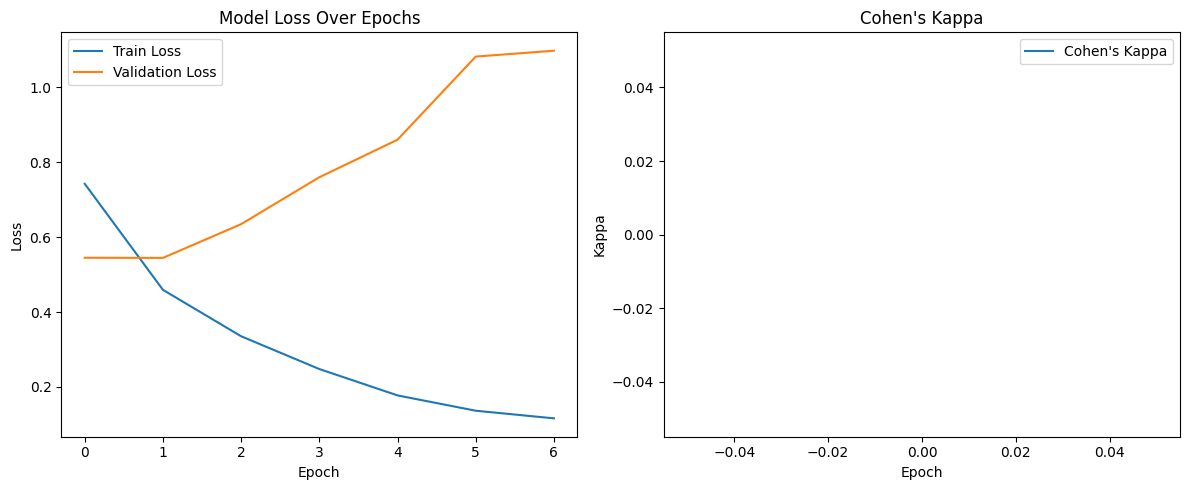

"\n1. **Hyperparameter Tuning:**\n   - The hyperparameter search is limited to `max_trials=10` for demonstration purposes.\n   - Adjust `max_trials` based on your computational resources and desired thoroughness.\n\n2. **Batch Size:**\n   - If `batch_size` is not part of the hyperparameter tuning, ensure to set it appropriately during training.\n   - You can include `batch_size` as a hyperparameter in the `build_model` function if desired.\n\n3. **Cohen's Kappa Visualization:**\n   - To track Cohen's Kappa over epochs, you can implement a custom callback that calculates and logs it at each epoch.\n   - This requires advanced customization and is optional.\n\n4. **Handling Class Imbalance:**\n   - If your dataset has imbalanced classes, consider implementing class weights during training.\n   - Example:\n     ```python\n     from sklearn.utils import class_weight\n     y_train_int = np.argmax(y_train, axis=1)\n     class_weights = class_weight.compute_class_weight(\n         class_weigh

In [ ]:
# =========================
# 1. Import Necessary Libraries
# =========================

import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import cohen_kappa_score, classification_report, f1_score
import keras_tuner as kt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Conv1D, MaxPooling1D, GlobalAveragePooling1D, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt
import warnings

# Suppress deprecation warnings for cleaner output
warnings.filterwarnings('ignore')

# =========================
# 3. Label Encoding and One-Hot Encoding
# =========================

# Initialize LabelEncoder and fit on the 'primary_label' column
label_encoder = LabelEncoder()
integer_labels = label_encoder.fit_transform(data_cleaned['primary_label'])

# One-Hot Encode using Keras's to_categorical
one_hot_labels = to_categorical(integer_labels)

# Determine the number of classes
num_classes = one_hot_labels.shape[1]

# Display the number of classes and class names
print(f"Number of classes: {num_classes}")
print(f"Classes: {label_encoder.classes_}")

# =========================
# 4. Text Tokenization and Padding
# =========================

# Define parameters
max_num_words = 10000  # Adjust based on your dataset
max_sequence_length = 100  # Adjust based on your data

# Initialize Tokenizer and fit on texts
tokenizer = Tokenizer(num_words=max_num_words, oov_token="<OOV>")
tokenizer.fit_on_texts(data_cleaned['resume'])
sequences = tokenizer.texts_to_sequences(data_cleaned['resume'])

# Pad sequences to ensure uniform input length
X_features = pad_sequences(sequences, maxlen=max_sequence_length, padding='post', truncating='post')

# =========================
# 5. Data Splitting
# =========================

# Split the data into Training (60%), Temporary (40%)
X_train, X_temp, y_train, y_temp = train_test_split(
    X_features, one_hot_labels,
    test_size=0.4,
    random_state=42,
    stratify=one_hot_labels
)

# Split Temporary into Validation (20%) and Test (20%)
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp,
    test_size=0.5,
    random_state=42,
    stratify=y_temp
)

# Verify the splits
print(f"Training set size: {X_train.shape[0]}")
print(f"Validation set size: {X_val.shape[0]}")
print(f"Test set size: {X_test.shape[0]}")

# =========================
# 6. Hyperparameter Tuning with Keras Tuner
# =========================

# Define the hypermodel
def build_model(hp):
    model = Sequential()

    # Embedding layer
    model.add(Embedding(
        input_dim=max_num_words,
        output_dim=hp.Choice('embedding_dim', values=[50, 100, 200]),
        input_shape=(max_sequence_length,)
    ))

    # Number of Conv1D layers
    for i in range(hp.Int('num_conv_layers', 1, 3)):
        model.add(Conv1D(
            filters=hp.Choice(f'filters_{i}', values=[64, 128, 256]),
            kernel_size=hp.Choice(f'kernel_size_{i}', values=[3,5,7]),
            activation='relu'
        ))
        model.add(MaxPooling1D(pool_size=hp.Choice(f'pool_size_{i}', values=[2,3,4])))

    # Global Average Pooling
    model.add(GlobalAveragePooling1D())

    # Dense layer
    model.add(Dense(
        units=hp.Choice('dense_units', values=[64, 128, 256]),
        activation='relu'
    ))

    # Dropout layer
    model.add(Dropout(rate=hp.Float('dropout_rate', min_value=0.3, max_value=0.7, step=0.1)))

    # Output layer
    model.add(Dense(num_classes, activation='softmax'))

    # Compile the model
    model.compile(
        optimizer=Adam(
            learning_rate=hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])
        ),
        loss='categorical_crossentropy',
        metrics=[]  # Exclude Keras metrics
    )

    return model

# Initialize the tuner
tuner = kt.RandomSearch(
    build_model,
    objective='val_loss',
    max_trials=10,  # Adjust based on computational resources
    executions_per_trial=1,
    directory='hyperparam_tuning',
    project_name='text_classification'
)

# Display search space summary
tuner.search_space_summary()

# Define Callbacks for Tuner
tuner_callbacks = [
    EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
]

# Run the hyperparameter search
tuner.search(
    X_train, y_train,
    epochs=10,
    validation_data=(X_val, y_val),
    callbacks=tuner_callbacks,
    verbose=1
)

# Get the optimal hyperparameters
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
print(f"\nBest Hyperparameters:")
for param in best_hps.values:
    print(f"{param}: {best_hps.get(param)}")

# =========================
# 7. Build and Train the Best Model
# =========================

# Build the model with the optimal hyperparameters
best_model = tuner.hypermodel.build(best_hps)

# Define Callbacks for Training
training_callbacks = [
    EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True),
    ModelCheckpoint('best_model_tuned.keras', monitor='val_loss', save_best_only=True, mode='min')
]

# Train the best model
history = best_model.fit(
    X_train, y_train,
    batch_size=best_hps.get('batch_size') if 'batch_size' in best_hps.values else 32,  # Adjust if batch_size is a hyperparameter
    epochs=50,  # Set a high epoch count; EarlyStopping will handle termination
    validation_data=(X_val, y_val),
    callbacks=training_callbacks,
    verbose=1
)

# =========================
# 8. Model Evaluation
# =========================

# Load the best saved model
best_model.load_weights('best_model_tuned.keras')

# ----------------------------
# A. Evaluate on Validation Set with Keras Metrics (Only Loss)
# ----------------------------

print("\nEvaluating on the Validation Set with Keras Metrics:")
results_val = best_model.evaluate(X_val, y_val, verbose=0)

# for metric, value in zip(best_model.metrics_names, results_val):
#     print(f"{metric}: {value:.4f}")

# ----------------------------
# B. Evaluate on Validation Set with Scikit-learn Metrics
# ----------------------------

# Predict class probabilities on validation set
y_pred_probs_val = best_model.predict(X_val)
y_pred_val = np.argmax(y_pred_probs_val, axis=1)
y_true_val = np.argmax(y_val, axis=1)

# Compute Cohen's Kappa
kappa_val = cohen_kappa_score(y_true_val, y_pred_val)
print(f"Cohen's Kappa (Validation Set): {kappa_val:.4f}")

# Compute Classification Report and F1-Score
report_val = classification_report(y_true_val, y_pred_val, target_names=label_encoder.classes_)
f1_val = f1_score(y_true_val, y_pred_val, average='weighted')

print("\nCNN Classification Report (Validation Set) - Scikit-learn:")
print(report_val)
print(f"F1-Score (Validation Set) - Scikit-learn: {f1_val:.4f}")

# Plot Training & Validation Loss
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Plot Training & Validation Accuracy if available
# Since we excluded Keras metrics, skip plotting them

plt.subplot(1, 2, 2)
plt.plot([], [], label="Cohen's Kappa")  # Placeholder for Cohen's Kappa
plt.title("Cohen's Kappa")
plt.xlabel('Epoch')
plt.ylabel('Kappa')
plt.legend()

plt.tight_layout()
plt.show()

# =========================
# 10. Save and Load the Final Model (Optional)
# =========================

# Save the entire model
best_model.save('final_model.h5')

# To load the model later:
# from tensorflow.keras.models import load_model
# final_model = load_model('final_model.h5')

# =========================
# 11. Additional Notes
# =========================

"""
1. **Hyperparameter Tuning:**
   - The hyperparameter search is limited to `max_trials=10` for demonstration purposes.
   - Adjust `max_trials` based on your computational resources and desired thoroughness.

2. **Batch Size:**
   - If `batch_size` is not part of the hyperparameter tuning, ensure to set it appropriately during training.
   - You can include `batch_size` as a hyperparameter in the `build_model` function if desired.

3. **Cohen's Kappa Visualization:**
   - To track Cohen's Kappa over epochs, you can implement a custom callback that calculates and logs it at each epoch.
   - This requires advanced customization and is optional.

4. **Handling Class Imbalance:**
   - If your dataset has imbalanced classes, consider implementing class weights during training.
   - Example:
     ```python
     from sklearn.utils import class_weight
     y_train_int = np.argmax(y_train, axis=1)
     class_weights = class_weight.compute_class_weight(
         class_weight='balanced',
         classes=np.unique(y_train_int),
         y=y_train_int
     )
     class_weights_dict = {i: weight for i, weight in enumerate(class_weights)}
     ```
   - Then include `class_weight=class_weights_dict` in the `model.fit()` function.

5. **Cross-Validation:**
   - For more robust hyperparameter tuning, consider using cross-validation techniques.
   - Keras Tuner can be integrated with cross-validation by modifying the hypermodel accordingly.

6. **Data Preprocessing Consistency:**
   - Ensure that all preprocessing steps (like tokenization and padding) are consistently applied across Training, Validation, and Test sets.

7. **Monitoring and Logging:**
   - Use TensorBoard or similar tools for more detailed monitoring of training metrics.
   - Example:
     ```python
     from tensorflow.keras.callbacks import TensorBoard
     tensorboard = TensorBoard(log_dir='./logs')
     history = best_model.fit(
         X_train, y_train,
         batch_size=batch_size,
         epochs=epochs,
         validation_data=(X_val, y_val),
         callbacks=[early_stopping, model_checkpoint, tensorboard],
         verbose=1
     )
     ```

8. **Model Complexity:**
   - Adjust the complexity of the model (number of layers, units, filters) based on the dataset size and problem complexity to avoid overfitting or underfitting.

9. **Saving Predictions:**
   - Optionally, save your predictions for further analysis or reporting.
   - Example:
     ```python
     # Save predictions on test set
     predictions = pd.DataFrame({
         'Text': data_cleaned['resume'][X_test.index],
         'True_Label': label_encoder.inverse_transform(y_true_test),
         'Predicted_Label': label_encoder.inverse_transform(y_pred_test)
     })
     predictions.to_csv('test_set_predictions.csv', index=False)
     ```

10. **Reproducibility:**
    - Set random seeds to ensure reproducible results.
    - Example:
      ```python
      import tensorflow as tf
      import random
      np.random.seed(42)
      random.seed(42)
      tf.random.set_seed(42)
      ```
"""



<ipython-input-15-6fb6d710e570>:24: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  bar_plot = sns.barplot(
/usr/local/lib/python3.10/dist-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/usr/local/lib/python3.10/dist-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/usr/local/lib/python3.10/dist-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a l

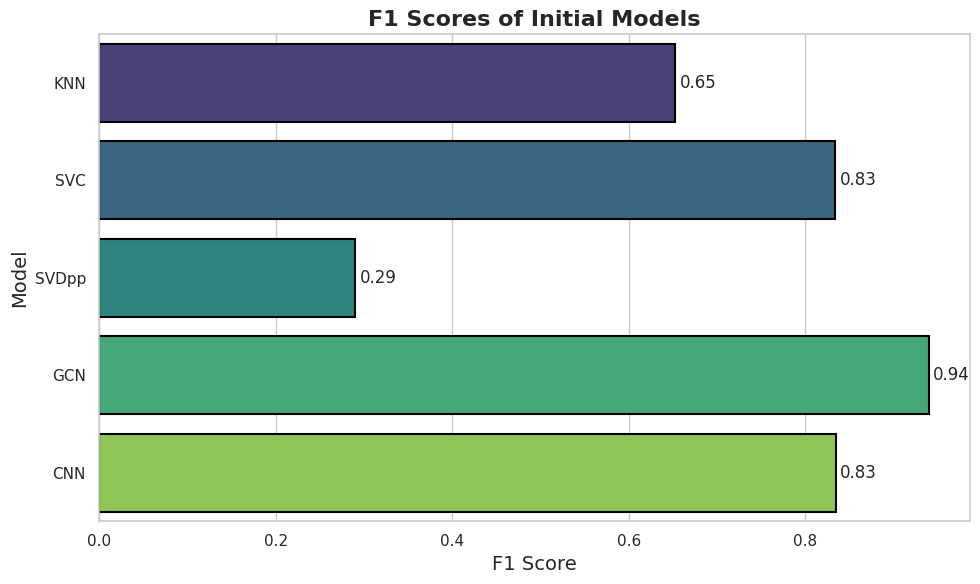

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# F1-scores of all models
f1_KNN = 0.6528
f1_SVC = 0.8338
f1_SVDpp = 0.2903
f1_GCN = 0.94
f1_CNN = 0.8347

models = ['KNN', 'SVC', 'SVDpp', 'GCN', 'CNN']
f1_scores = [f1_KNN, f1_SVC, f1_SVDpp, f1_GCN, f1_CNN]

data = {'Model': models, 'F1-Score': f1_scores}
df = pd.DataFrame(data)

sns.set(style="whitegrid")
plt.figure(figsize=(10, 6))
bar_plot = sns.barplot(
    x='F1-Score',
    y='Model',
    data=data,
    palette='viridis',
    edgecolor='black',
    linewidth=1.5
)

plt.title('F1 Scores of Initial Models', fontsize=16, fontweight='bold')
plt.xlabel('F1 Score', fontsize=14)
plt.ylabel('Model', fontsize=14)

for index, value in enumerate(data['F1-Score']):
    plt.text(value + 0.005, index, f"{value:.2f}", va='center', fontsize=12)

plt.tight_layout()
plt.show()